# Supporting Code

### import libraries

In [496]:
import pandas as pd
import xml.etree.ElementTree as ET
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import zipfile
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import time
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from copy import copy

### helper functions and classes

In [5]:
# Function to extract and parse XML from a zip file
def extract_and_parse_xml(zip_path, file_name):
    # use the xipfile library to get the content => https://docs.python.org/3/library/zipfile.html
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        with zip_ref.open(file_name) as xml_file:
            # Read the content of the file
            xml_content = xml_file.read()
            # Parse the XML to a python object => https://docs.python.org/3/library/xml.etree.elementtree.html
            root = ET.fromstring(xml_content)
    return root

In [7]:
# helper to find a specific row in the tournament summary file
def find_row(filepath, content):
    with open(filepath, 'r') as file:
        for i, line in enumerate(file):
            if content in line:
                return i
    return -1

# define search terms globally, they are standard for all tournaments
# this tells us where the list of games begins
header_content = 'iteration\tmap\tai1\tai2\ttime\twinner\tcrashed\ttimedout'
# this tells us where the list of models ends
maps_header_content = 'maps'
# this tells us where the footer starts. If the tournament was force-stopped, there will be no footer
footer_start = 'Wins:'

### Main Tournament Analysis Class

In [559]:
# class to define an object containing tournament traces
class TournamentAnalysis:

    #### CONSTRUCTOR ####
    # loads games and traces of the of the tournament
    def __init__(self, name, fraction=1.0):
        self.name = name
        
        # the path to the tournament summary file
        tournament_summary_file = 'C:/source/MicroRTS/' + name + '/tournament.csv'
   
        # Find the number of models used in this tournament
        n_models = find_row(tournament_summary_file, maps_header_content) - 2
        
        # read in the model names
        ai_models = pd.read_table(tournament_summary_file, usecols=[1], sep='\t', skiprows=1, nrows=n_models)
        ai_models_list = ai_models.iloc[:,0].tolist()
        # create a dict so we can use map()
        model_names_dict = {i: name.split('(')[0] for i, name in enumerate(ai_models_list)}
        
        # Find the row number of the header
        header_row = find_row(tournament_summary_file, header_content)

        # calculate the length of the footer in the tournament file
        footer_length = 0
        if (find_row(tournament_summary_file, footer_start) != -1):
            footer_length = (n_models * 7) + 7
            
        # load the tournament summary into a dataframe
        df_games = pd.read_table(tournament_summary_file, sep='\t', skiprows=header_row, skipfooter=footer_length, engine='python')

        # Truncate he dataframe to the proportion provided by the user
        max_rows = int(len(df_games) * fraction)
        df_games = df_games.iloc[:max_rows]
     
        # add the model names to the dataframe
        df_games['ai1_name'] = df_games['ai1'].map(model_names_dict)
        df_games['ai2_name'] = df_games['ai2'].map(model_names_dict)
        
        # winner columns, so we know which column won
        df_games['winning_model'] = np.where(df_games['winner'] == 0, df_games['ai1'], np.where(df_games['winner'] == 1, df_games['ai2'], -1))
        df_games['winning_model_name'] = df_games['winning_model'].map(model_names_dict)
        # loser columns, so we know which model was beaten
        df_games['losing_model'] = np.where(df_games['winner'] == 0, df_games['ai2'], np.where(df_games['winner'] == 1, df_games['ai2'], -1))
        df_games['losing_model_name'] = df_games['losing_model'].map(model_names_dict)

        # Initialize list to hold trace data
        trace_data = []
        # the path where traces are stored
        traces_path = 'C:/source/MicroRTS/' + self.name + '/traces/'
        
        # loop through all games in the tournament summary
        for index, row in df_games.iterrows():
        
            # compose the filename where the traces for this game will be stored
            filename = "%d-vs-%d-%d-%d.zip" % (row['ai1'], row['ai2'], row['map'], row['iteration']) 
            # Load the XML file
            root = extract_and_parse_xml(traces_path + filename, 'game.xml')
            
            # Iterate through each TraceEntry to extract timestep data
            for entry in root.findall('.//rts.TraceEntry'):
                # timestep ID if this TraceEntry in the game
                time = int(entry.get('time'))
                
                # Extract players' data
                players = entry.findall('.//rts.Player')
                player_data = {f"player_{player.get('ID')}_resources": int(player.get('resources')) for player in players}
                
                # Initialize counters for unit types
                unit_counts = defaultdict(int)
                
                # Extract units - count unit types for each player
                units = entry.findall('.//rts.units.Unit')
                for unit in units:
                    unit_type = unit.get('type')
                    player_id = unit.get('player')
                    if player_id != '-1':  # Exclude neutral units like resources
                        unit_counts[f"player_{player_id}_{unit_type}_units"] += 1
                
                # Extract actions' data
                action_counts = defaultdict(int)
                # get an array of action tags
                actions = entry.findall('.//action')
                # loop through each action
                for action in actions:
                    # the unit that the action was performed on
                    unit_id = action.get('unitID')
                    # the action that was performed
                    unit_action = action.find('UnitAction')
                    # if an action was defined
                    if unit_action is not None:
                        # action details
                        action_type = unit_action.get('type')
                        parameter = unit_action.get('parameter')
                        for unit in units:
                            if unit.get('ID') == unit_id:
                                player_id = unit.get('player')
                                break
                        # create columns for player and action type, or player and parameter
                        action_counts[f"player_{player_id}_action_type_{action_type}_count"] += 1
                        action_counts[f"player_{player_id}_action_parameter_{parameter}_count"] += 1
                
                # Combine data for this timestep
                timestep_data = {'time': time}
                timestep_data.update(player_data)
                timestep_data.update(unit_counts)
                timestep_data.update(action_counts)
        
                # add label columns
                timestep_data['opponent'] = row['ai2_name']
                timestep_data['game_id'] = filename
                
                # Add to data list of traces
                trace_data.append(timestep_data)
        
        # Create DataFrame from the traces
        df = pd.DataFrame(trace_data)
        
        # Fill NaN values with 0 (in case there are no actions of certain types in some timesteps)
        df = df.fillna(0)

        # Set properties on this object
        self.games = df_games
        self.models = model_names_dict
        self.model_names = ai_models_list
        self.traces = df  
        self.n_models = n_models
    
    #### PREPROCESSING ####
    # preprocesses data into sliding windows and train-test split
    def preprocess(self, window_size = 5, test_size=0.2):
        X, y = [], []
        i = 0
        self.window_size = window_size
        df = self.traces
        # loop through the timestep data
        while i < len(df) - window_size:
            # make sure the next N traces are within the same game (don't want to mix games in a window)
            if df.iloc[i]['game_id'] == df.iloc[i + window_size]['game_id']:
                # Take take N traces at a time
                window = df.iloc[i:i + window_size]
                X.append(window.drop(columns=['time', 'game_id', 'opponent']).values)
                # Use the opponent label at the end of the window
                y.append(window['opponent'].iloc[-1])
                # increment i to make a sliding window starting with the next
                i += 1
            else:
                # we need to skip to start a new window at the next different value
                i = i + window_size - 1

        X = np.array(X)
        self.X_unflat = X
        self.X_columns = [col for col in t12.traces.columns if col not in ['opponent', 'time', 'game_id']]
        self.y = np.array(y)

        # Encode the opponent labels
        self.label_encoder = LabelEncoder()
        y_encoded = self.label_encoder.fit_transform(y)

        # We need to flatten the X array for Scikit-Learn
        num_samples, window_size, num_features = X.shape
        # Flatten each window
        self.X = np.array([window.flatten() for window in X])
        
        # Split the data into training and testing sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size, random_state=42, stratify=self.y)

    #### TRAIN ####
    def train(self):
        # Initialize the classifier
        self.classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        
        # Train the classifier
        self.classifier.fit(self.X_train, self.y_train)

    #### EVALUATE ####
    def evaluate(self, X_test, y_test):
        # Make predictions on the test set
        y_pred = self.classifier.predict(X_test)
        # Evaluate performance
        print("Overall accuracy:", accuracy_score(y_test, y_pred))
        print("Report:")
        print(classification_report(y_test, y_pred, target_names=self.label_encoder.classes_))
        return y_pred

    #### CLUSTERING ####
    
    def elbowForOptimalK(self, max=10, figsize=(10, 5)):
        # Determine the optimal number of clusters using the elbow method
        wcss = []
        for i in range(1, 11):
            kmeans = KMeans(n_clusters=i, random_state=42)
            kmeans.fit(self.X)
            wcss.append(kmeans.inertia_)
        
        # Plot the elbow graph
        plt.figure(figsize=figsize)
        plt.plot(range(1, max), wcss, marker='o')
        plt.title('Elbow Method For Optimal k')
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS')
        plt.show()

    def cluster(self, k_clusters):
        # set local variables to use for clustering
        df = self.traces
        X_flat = self.X
        
        # Fit K-Means with the optimal number of clusters
        kmeans = KMeans(n_clusters=k_clusters, random_state=42)
        y_kmeans = kmeans.fit_predict(X_flat)
        self.y_kmeans = y_kmeans
        self.k_clusters = k_clusters
                
        # Add a column for cluster labels to the dataframe
        df['cluster'] = np.nan
        
        # Ensure the cluster labels are assigned correctly
        for i in range(len(y_kmeans)):
            df.iloc[i:i + self.window_size, df.columns.get_loc('cluster')] = y_kmeans[i]
        
        # Calculate PCA component to graph the clusters in 2d
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_flat)

        # plot the cluster diagram
        plt.figure(figsize=(10, 5))
        for cluster in np.unique(y_kmeans):
            color = plt.cm.nipy_spectral(float(cluster) / len(np.unique(y_kmeans)))
            label = f'Cluster {cluster}'
            plt.scatter(X_pca[y_kmeans == cluster, 0], X_pca[y_kmeans == cluster, 1], color=color, label=label)
        plt.title('K-Means Clusters of Opponents')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.legend()
        plt.show()
        

    def clusterBarchart(self, k_clusters, figsize=(10, 7)):        
        # Encode the opponent column
        label_encoder_opponent = LabelEncoder()
        opponent_encoded = label_encoder_opponent.fit_transform(self.y)
        opponent_names = label_encoder_opponent.inverse_transform(opponent_encoded)
        
        # Truncate opponent names at the first opening bracket "("
        truncated_opponent_names = [name.split('(')[0].strip() for name in opponent_names]
        
        # Create a DataFrame with opponent and cluster labels
        cluster_df = pd.DataFrame({'opponent': truncated_opponent_names, 'cluster': self.y_kmeans})
        
        # Create a pivot table for the stacked bar chart
        pivot_table = cluster_df.pivot_table(index='opponent', columns='cluster', aggfunc=len, fill_value=0)
        
        # Plot the stacked bar chart
        pivot_table.plot(kind='bar', stacked=True, colormap='tab10', figsize=figsize)
        
        plt.title('Distribution of Clusters Across Opponents')
        plt.xlabel('Opponent')
        plt.ylabel('Number of Samples')
        plt.legend(title='Cluster')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def clusterByOpponent(self, k_clusters):
        df = self.traces
        X_flat = self.X
        y = self.y
        
        # Encode the opponent column
        label_encoder_opponent = LabelEncoder()
        opponent_encoded = label_encoder_opponent.fit_transform(y)
        
        # Fit K-Means with the optimal number of clusters
        kmeans = KMeans(n_clusters=k_clusters, random_state=42)
        y_kmeans = kmeans.fit_predict(X_flat)
        self.y_kmeans = y_kmeans
        
        # Ensure the lengths of X_flat and y_kmeans are the same
        assert len(X_flat) == len(y_kmeans), "Mismatch in number of samples between X_flat and y_kmeans"
        assert len(y_kmeans) == len(opponent_encoded), "Mismatch in number of samples between y_kmeans and opponent_encoded"
        
        # Add the cluster labels to the original dataframe
        df['cluster'] = np.nan
        
        # Ensure the cluster labels are assigned correctly
        for i in range(len(y_kmeans)):
            df.iloc[i:i + self.window_size, df.columns.get_loc('cluster')] = y_kmeans[i]
        
        # Reduce dimensionality for visualization
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_flat)
        
        # Plot each opponent separately
        unique_opponents = np.unique(opponent_encoded)
        colors = plt.cm.get_cmap('tab10', k_clusters)
        
        for opponent in unique_opponents:
            mask = opponent_encoded == opponent
            opponent_name = label_encoder_opponent.inverse_transform([opponent])[0]
            
            plt.figure(figsize=(12, 8))
            for cluster in np.unique(y_kmeans):
                cluster_mask = (y_kmeans == cluster) & mask
                plt.scatter(
                    X_pca[cluster_mask, 0], 
                    X_pca[cluster_mask, 1], 
                    color=colors(cluster), 
                    label=f'Cluster {cluster}'
                )
            
            plt.title(f'K-Means Clusters for Opponent: {opponent_name}')
            plt.xlabel('PCA Component 1')
            plt.ylabel('PCA Component 2')
            plt.legend()
            plt.show()

    def GetXByCluster(self, n):
        # Get the indices of the rows that belong to cluster 2
        cluster_indices = np.where(self.y_kmeans == n)[0]
        
        # Extract the rows corresponding to cluster 2 from X_flat
        return self.X_unflat[cluster_indices]
        
        # TO DO: create a DataFrame for easier analysis
        #df_cluster_2 = pd.DataFrame(X_cluster_2, columns=[f"feature_{i}" for i in range(X_flat.shape[1])])

    def ClusterTraceChart(self, n, figsize=(10, 8)):
        traces = self.GetXByCluster(n)

        # Exclude the two columns related to player total resources
        X_filtered = traces[:, :, 2:]
        column_names_filtered = self.X_columns[2:-1]
        
        # Sum the values across all windows and timesteps for each column
        column_sums = X_filtered.sum(axis=(0, 1))
        
        # Calculate the average for each column
        column_averages = X_filtered.mean(axis=(0, 1))
        
        # Plotting the horizontal bar chart
        plt.figure(figsize=figsize)
        y_pos = np.arange(len(column_names_filtered))
        
        plt.barh(y_pos, column_sums, align='center', alpha=0.7, label='Sum')
        plt.plot(column_averages, y_pos, 'r--', label='Average', marker='o')
        
        # Add inline labels for the average values
        for i, avg in enumerate(column_averages):
            plt.text(avg, y_pos[i], f'            avg: {avg:.2f}', color='red', va='center', ha='left', fontsize=9)
        
        # Add labels and title
        plt.yticks(y_pos, column_names_filtered)
        plt.xlabel('Sum of Values')
        plt.title('Sum of Each Column with Average Trend Line')
        
        # Add a legend
        plt.legend()
        
        # Display the plot
        plt.tight_layout()
        plt.show()


    ### MISC Analysis

    def PlotGameLength(self, bins = [0, 50, 100, 250, 500, 1000, 2000, 3000], figsize=(8, 4)):
        
        # Create time bins using pd.cut
        self.games['time_bins'] = pd.cut(self.games['time'], bins=bins)
        
        # Group by the 'time_bins' and count occurrences
        grouped = self.games['time_bins'].value_counts(sort=False)
    
        # Plot the bar chart
        grouped.plot(kind='bar', figsize=figsize, color='skyblue', edgecolor='black')
    
        # Add labels and title
        plt.title('Number of Games by Duration')
        plt.xlabel('Game Duration (timesteps range)')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
        plt.grid(axis='y')
    
        # Show the plot
        plt.show()

    def GameLengthByOpponent(self, bins = [0, 50, 100, 250, 500, 1000, 2000, 3000], figsize=(8, 4)):
        
        # Define the bins for time (e.g., you can modify the ranges to fit your data better)
        self.games['time_bins'] = pd.cut(self.games['time'], bins=bins)  # Create time bins
        
        # Group by the 'time_bins' and 'ai2_name' columns, and count occurrences
        grouped = self.games.groupby(['time_bins', 'ai2_name']).size().unstack(fill_value=0)
        
        # Plot the stacked bar chart
        grouped.plot(kind='bar', stacked=True, figsize=figsize, colormap='tab20')
        
        # Add labels and title
        plt.title('Number of Games by Duration and Opponent')
        plt.xlabel('Game Duration (timesteps range)')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
        plt.legend(title='Opponent')
        plt.grid(axis='y')
        
        # Show the plot
        plt.show()

    def PlotGameOpponent(self, figsize=(8, 4)):
        
        # Count the occurrences of each value in 'ai2_name'
        ai2_name_counts = self.games['ai2_name'].value_counts()
        
        # Create a bar chart
        plt.figure(figsize=figsize)
        ai2_name_counts.plot(kind='bar', color='skyblue', edgecolor='black')
        
        # Add labels and title
        plt.title('Games by Opponent')
        plt.xlabel('Opponent')
        plt.ylabel('No. of Games')
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
        plt.grid(axis='y')
        
        # Show the plot
        plt.show()
    
    def PlotTraceOpponent(self, figsize=(8, 4)):
        
        # Count the occurrences of each value in 'ai2_name'
        ai2_name_counts = self.traces['opponent'].value_counts()
        
        # Create a bar chart
        plt.figure(figsize=figsize)
        ai2_name_counts.plot(kind='bar', color='skyblue', edgecolor='black')
        
        # Add labels and title
        plt.title('Traces by Opponent')
        plt.xlabel('Opponent')
        plt.ylabel('No. of Traces')
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
        plt.grid(axis='y')
        
        # Show the plot
        plt.show()

# Experiments

### tournament 12

In [305]:
%%time
t12 = TournamentAnalysis("tournament_12")

CPU times: total: 7.83 s
Wall time: 32.7 s


In [110]:
%%time
t13 = TournamentAnalysis("tournament_13")

CPU times: total: 12.2 s
Wall time: 25.2 s


In [195]:
%%time
t12.preprocess()

CPU times: total: 22.8 s
Wall time: 56.6 s


In [111]:
%%time
t13.preprocess()

CPU times: total: 26.4 s
Wall time: 47 s


In [13]:
%%time
t12.train()

CPU times: total: 5.38 s
Wall time: 19.8 s


In [112]:
%%time
t13.train()

CPU times: total: 4.59 s
Wall time: 6.28 s


In [67]:
t12.evaluate(t12.X_test, t12.y_test)

Overall accuracy: 0.9475753210899052
Report:
                                                                                                        precision    recall  f1-score   support

                                                                              CoacAI(AStarPathFinding)       1.00      1.00      1.00     12044
                                                                           LightRush(AStarPathFinding)       1.00      0.98      0.99      5908
NaiveMCTS(100, -1, 100,10,0.3, 1.0, 0.0, 1.0, 0.4, 1.0, RandomBiasedAI, SimpleSqrtEvaluationFunction3)       0.98      0.98      0.98      6506
                                                                                             PassiveAI       0.98      0.99      0.99      2197
                                              PortfolioAI(100, -1, 100, SimpleSqrtEvaluationFunction3)       0.79      0.75      0.77      3475
                                                                          WorkerRush(AStar

array(['NaiveMCTS(100, -1, 100,10,0.3, 1.0, 0.0, 1.0, 0.4, 1.0, RandomBiasedAI, SimpleSqrtEvaluationFunction3)',
       'PassiveAI', 'CoacAI(AStarPathFinding)', ...,
       'NaiveMCTS(100, -1, 100,10,0.3, 1.0, 0.0, 1.0, 0.4, 1.0, RandomBiasedAI, SimpleSqrtEvaluationFunction3)',
       'CoacAI(AStarPathFinding)', 'PassiveAI'], dtype='<U102')

In [95]:
t13.evaluate(t13.X_test, t13.y_test)

Overall accuracy: 0.83649859569346
Report:
                                                                                           precision    recall  f1-score   support

                                                               CRush_V1(AStarPathFinding)       1.00      1.00      1.00      3522
                                                           HeavyDefense(AStarPathFinding)       1.00      1.00      1.00      3570
          MLPSMCTS(100, -1, 100, 10, 0.05, RandomBiasedAI, SimpleSqrtEvaluationFunction3)       0.40      0.31      0.35      2130
UCTFirstPlayUrgency(100, -1, 100, 10, RandomBiasedAI, SimpleSqrtEvaluationFunction3, 0.0)       0.44      0.55      0.49      2130
                                                             WorkerRush(AStarPathFinding)       1.00      1.00      1.00      3602

                                                                                 accuracy                           0.84     14954
                                      

array(['WorkerRush(AStarPathFinding)', 'HeavyDefense(AStarPathFinding)',
       'HeavyDefense(AStarPathFinding)', ...,
       'CRush_V1(AStarPathFinding)',
       'UCTFirstPlayUrgency(100, -1, 100, 10, RandomBiasedAI, SimpleSqrtEvaluationFunction3, 0.0)',
       'CRush_V1(AStarPathFinding)'], dtype='<U89')

C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

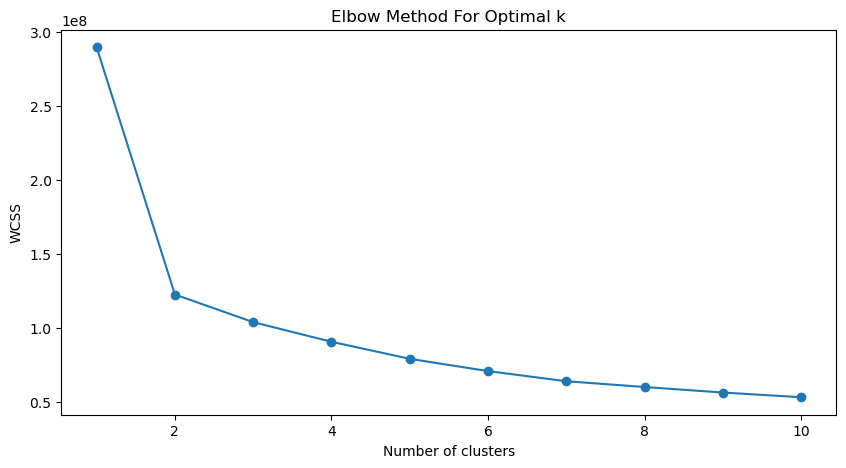

CPU times: total: 6min 39s
Wall time: 1min 13s


In [75]:
%%time
t12.elbowForOptimalK()

C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

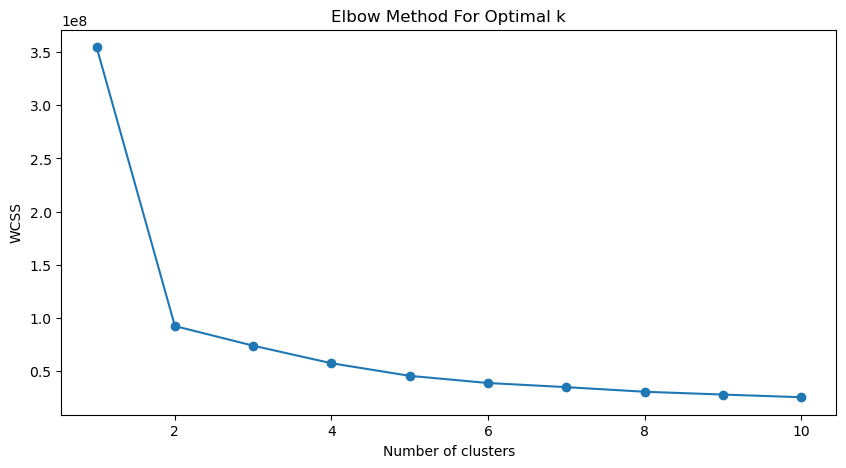

CPU times: total: 1min 36s
Wall time: 18.6 s


In [97]:
%%time
t13.elbowForOptimalK()

C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


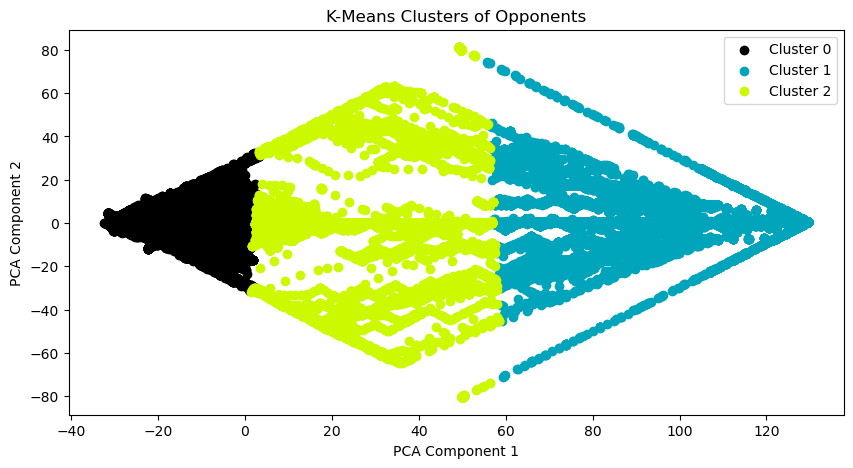

In [196]:
t12.cluster(3);

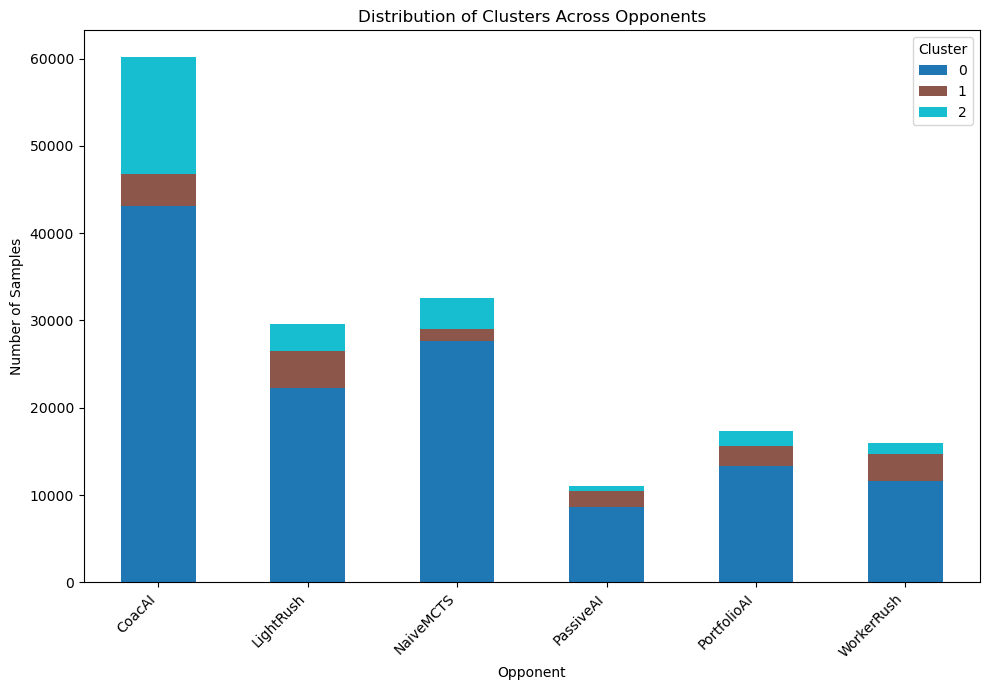

In [68]:
t12.clusterBarchart(3);

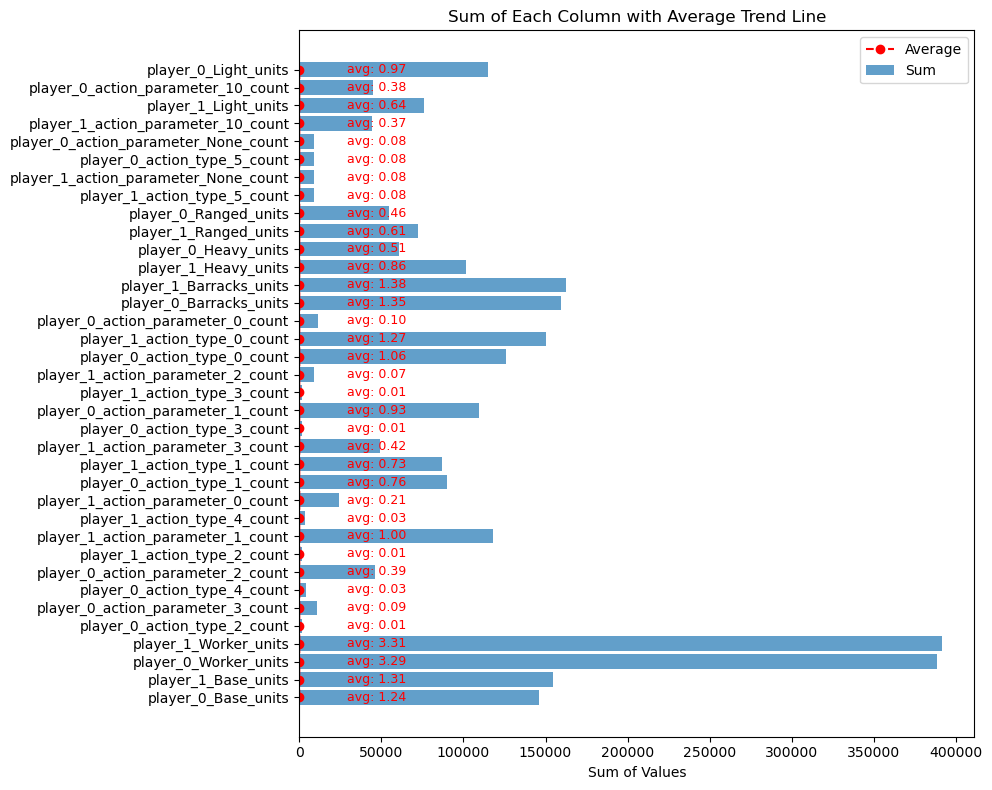

In [199]:
t12.ClusterTraceChart(2)

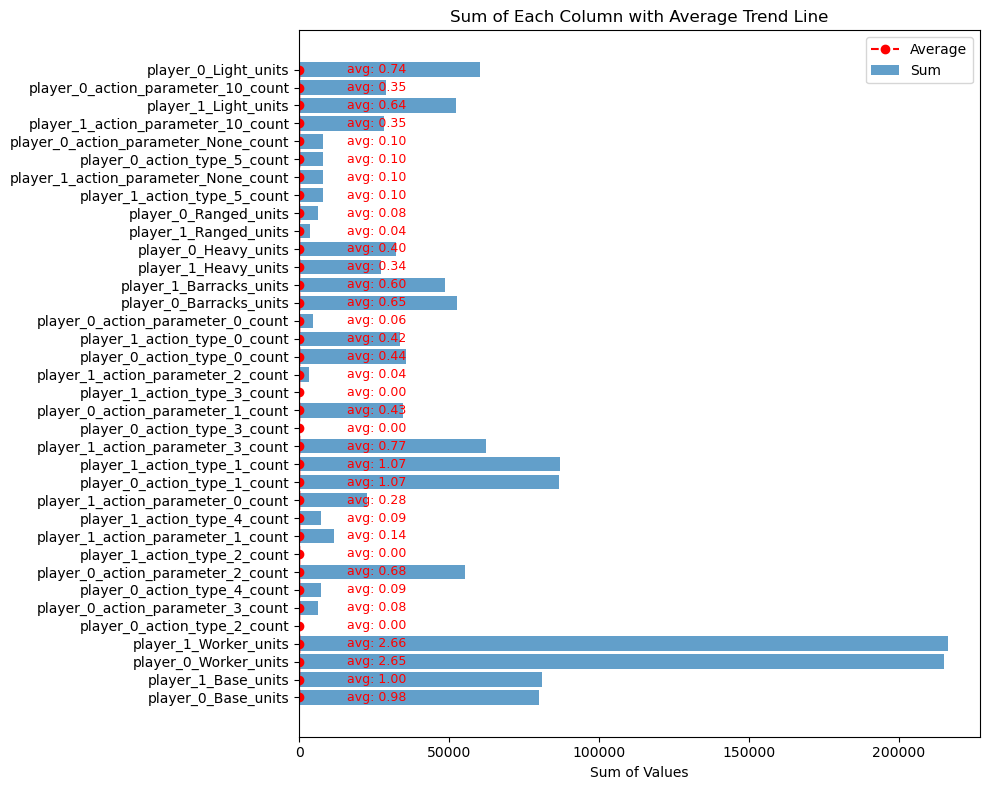

In [201]:
a = t12.ClusterTraceChart(1)

In [119]:
len(a[0][0])

38

In [99]:
len(t12.X[0])

190

In [101]:
t12.traces.head()

,time,player_0_resources,player_1_resources,player_0_Base_units,player_1_Base_units,player_0_Worker_units,player_1_Worker_units,opponent,game_id,player_0_action_type_2_count,...,player_0_Ranged_units,player_1_action_type_5_count,player_1_action_parameter_None_count,player_0_action_type_5_count,player_0_action_parameter_None_count,player_1_action_parameter_10_count,player_1_Light_units,player_0_action_parameter_10_count,player_0_Light_units,cluster
0,0,5,5,1.0,1.0,1.0,1.0,CoacAI(AStarPathFinding),0-vs-0-0-0.zip,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,5,5,1.0,1.0,1.0,1.0,CoacAI(AStarPathFinding),0-vs-0-0-0.zip,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20,5,5,1.0,1.0,1.0,1.0,CoacAI(AStarPathFinding),0-vs-0-0-0.zip,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,30,5,5,1.0,1.0,1.0,1.0,CoacAI(AStarPathFinding),0-vs-0-0-0.zip,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,40,6,6,1.0,1.0,1.0,1.0,CoacAI(AStarPathFinding),0-vs-0-0-0.zip,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


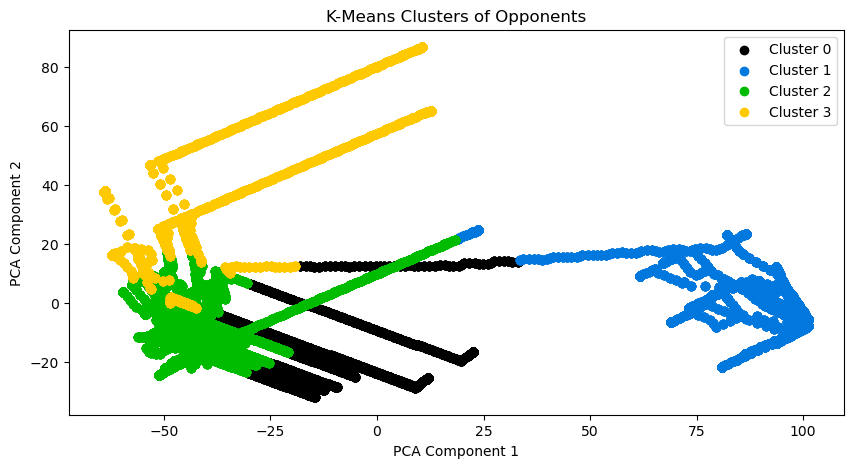

In [113]:
t13.cluster(4);

C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


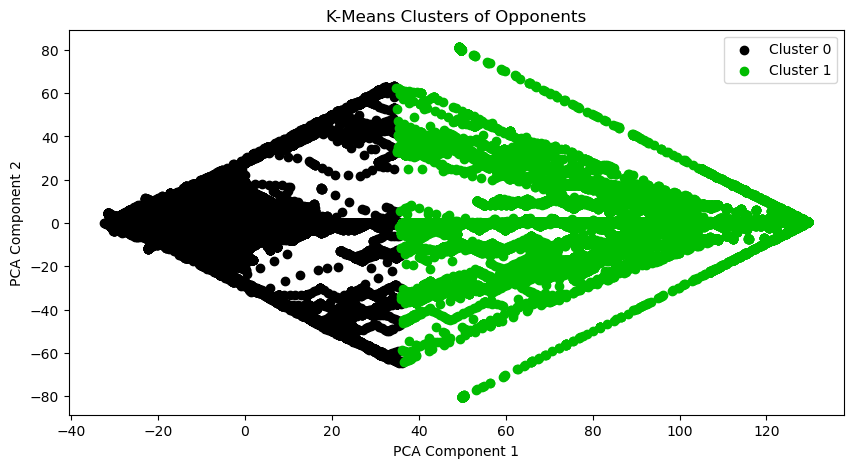

In [81]:
t12.cluster(2);

C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


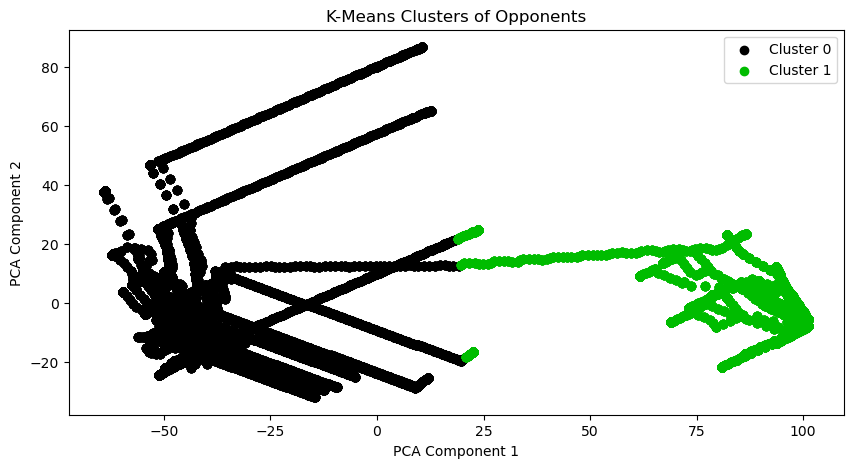

In [118]:
t13.cluster(2);

Shape of X_flat: (166618, 190)
Shape of opponent_encoded: (166618,)


C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tadhg\AppData\Local\Temp\ipykernel_23728\1240969211.py:264: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', k_clusters)


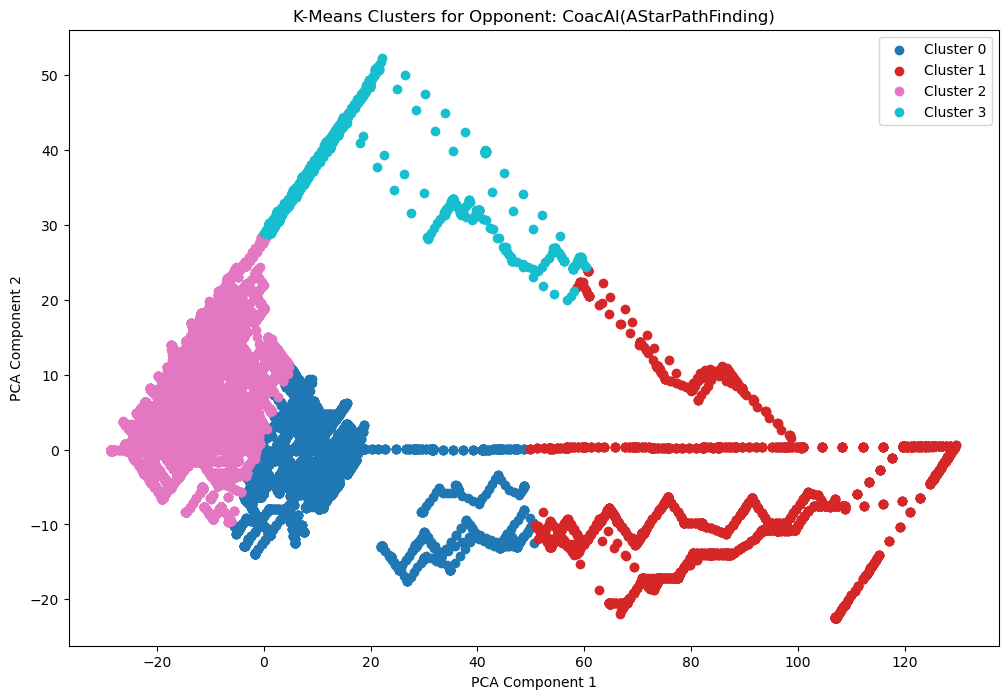

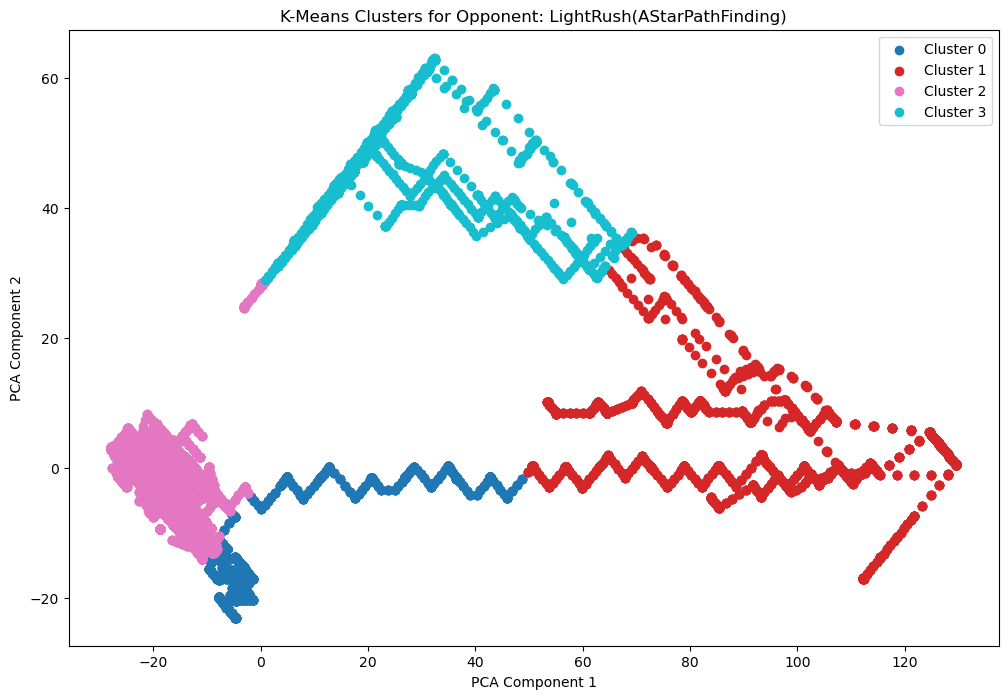

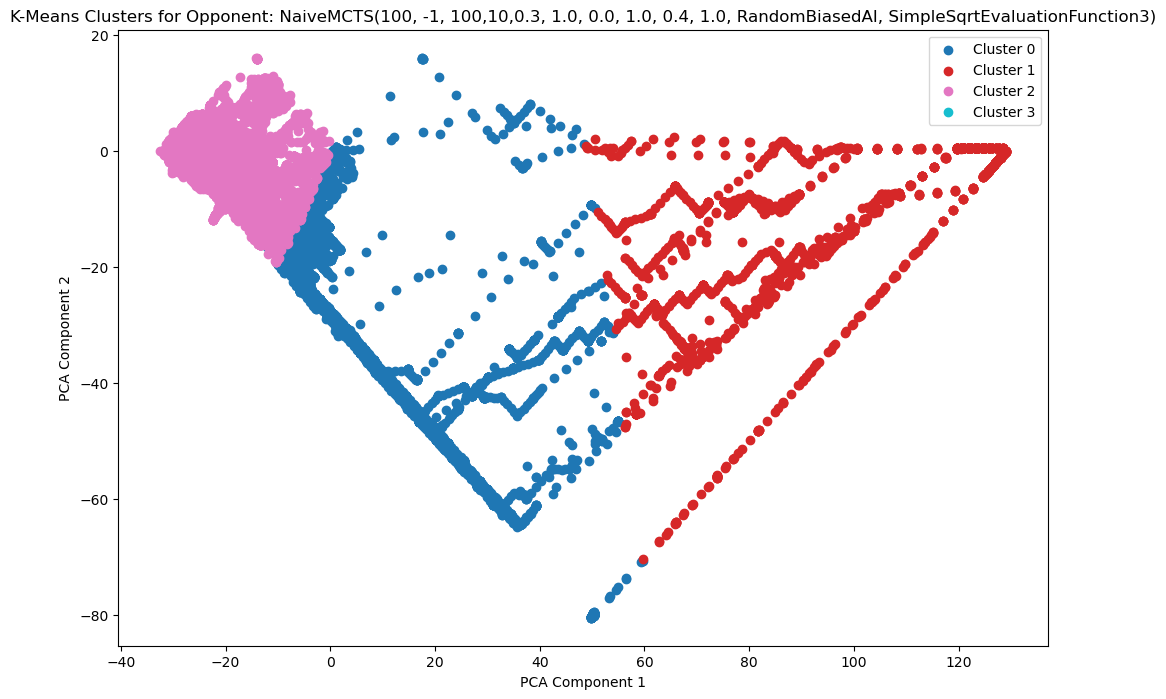

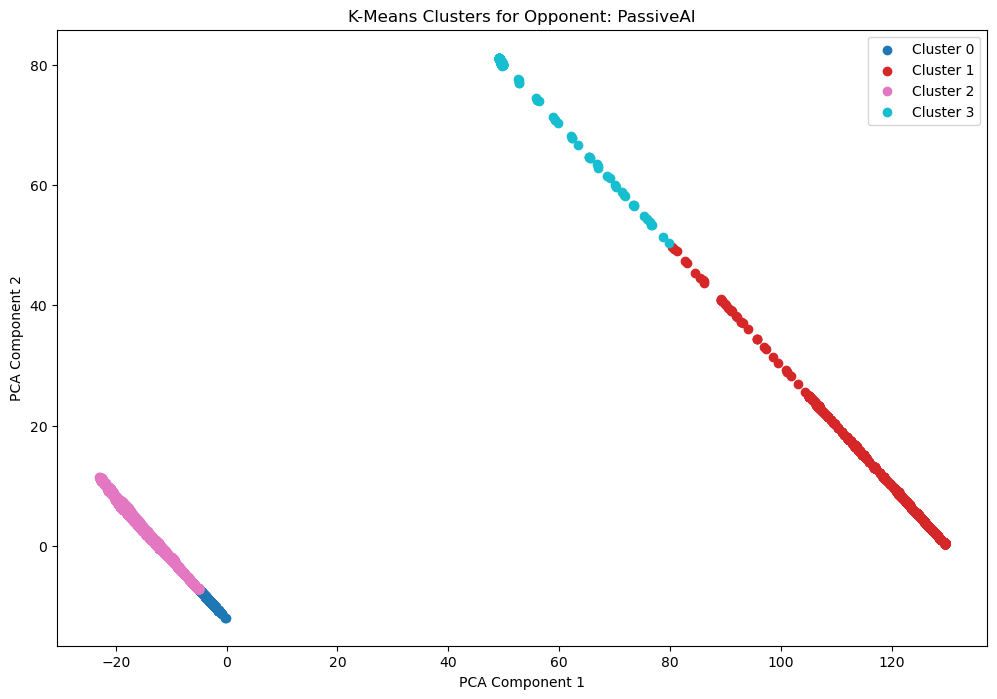

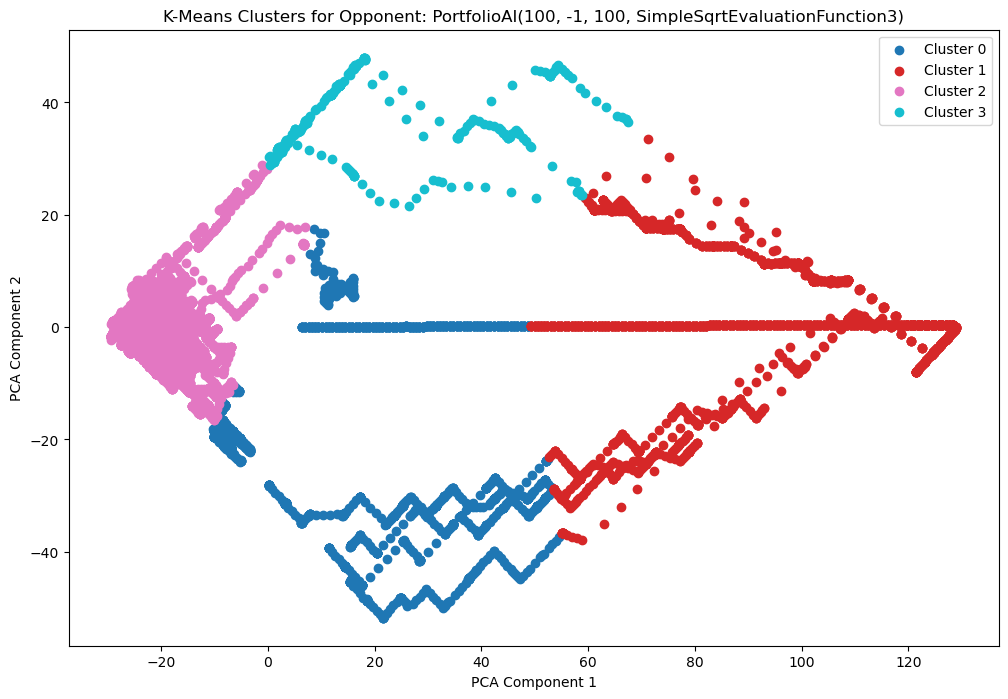

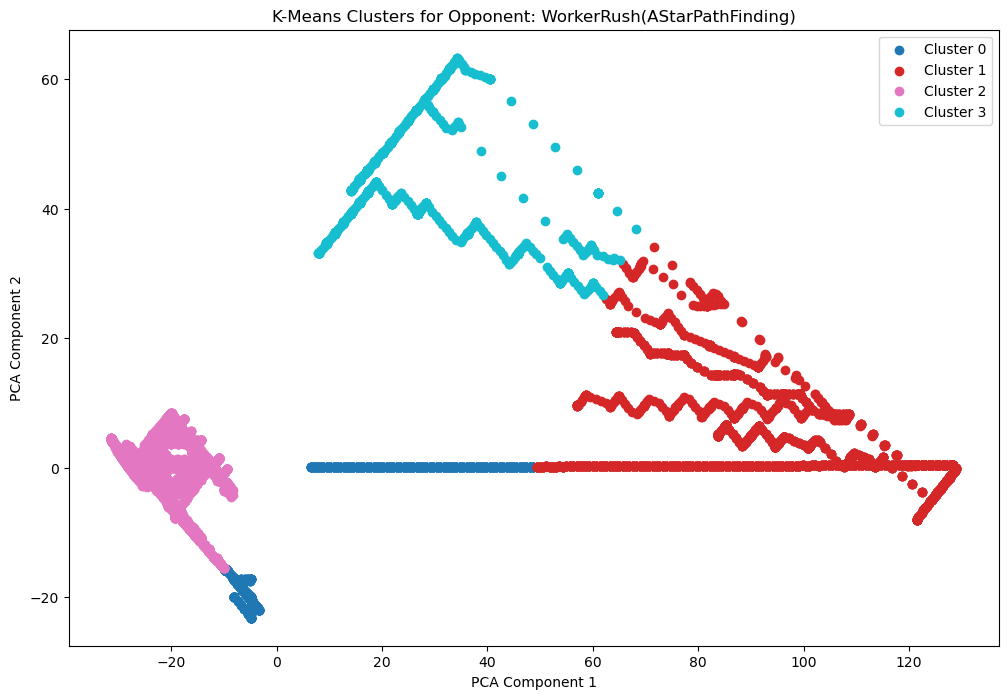

In [79]:
t12.clusterByOpponent(4)

Shape of X_flat: (74767, 160)
Shape of opponent_encoded: (74767,)


C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tadhg\AppData\Local\Temp\ipykernel_23728\156324518.py:267: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', k_clusters)


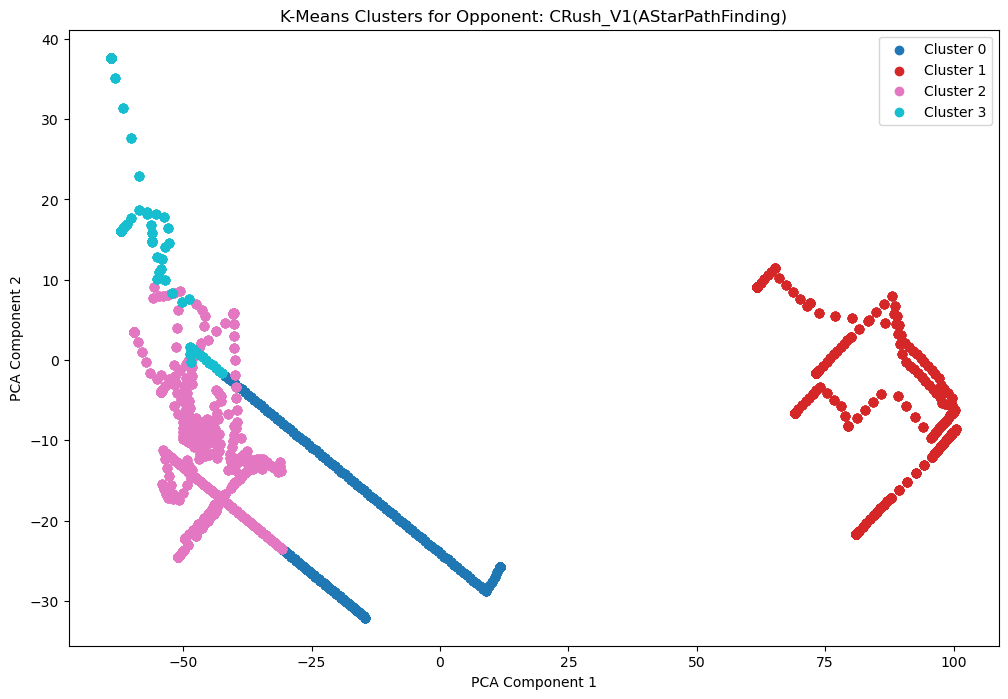

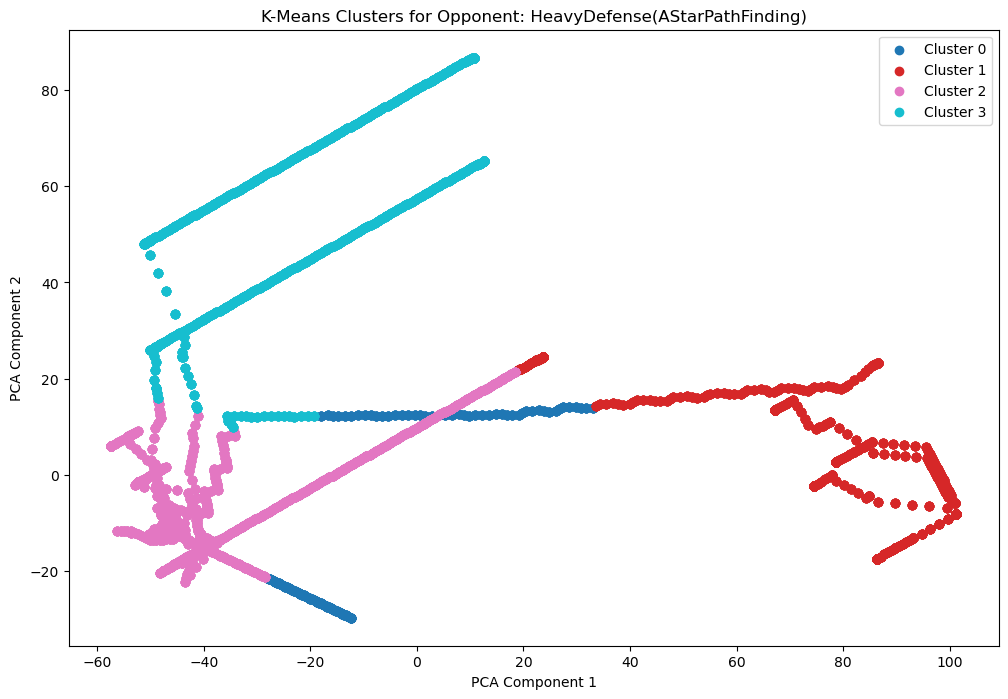

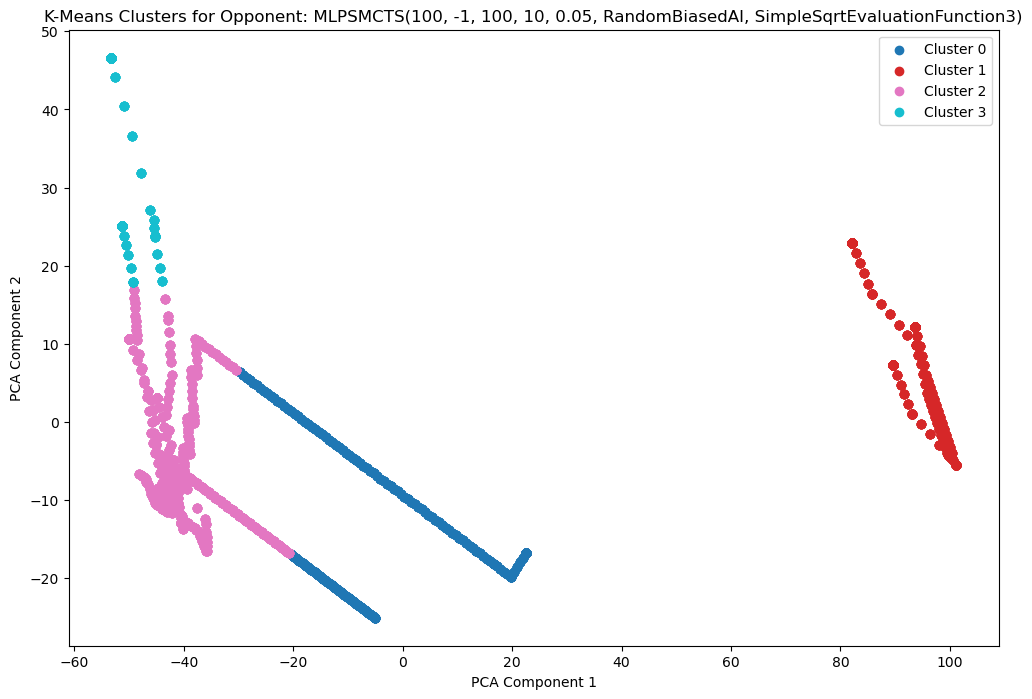

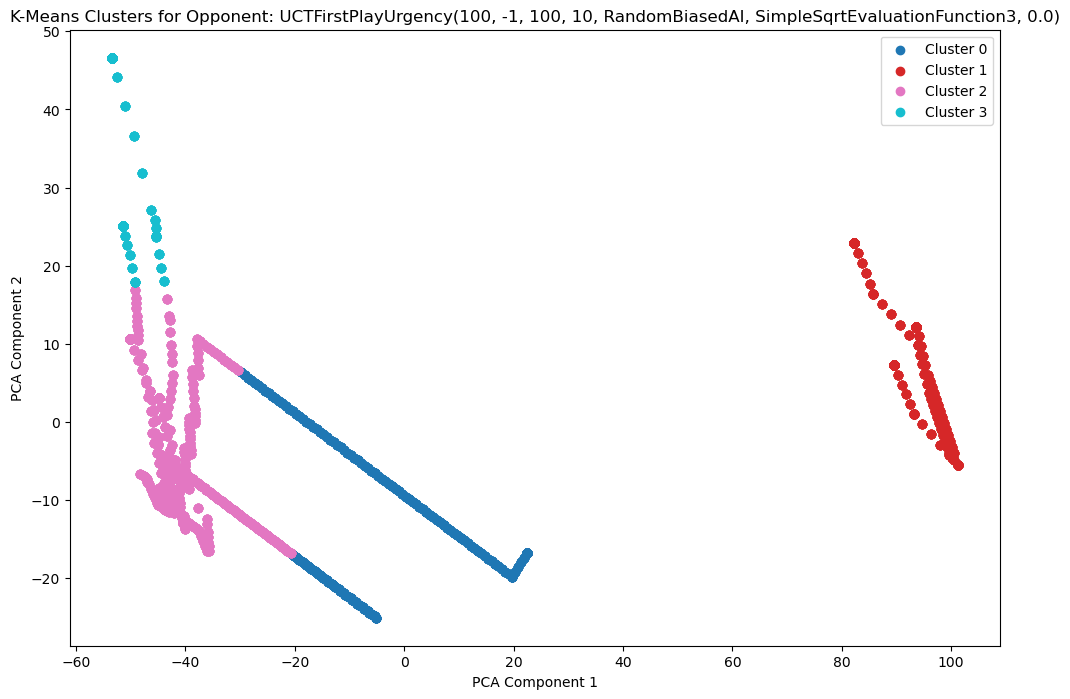

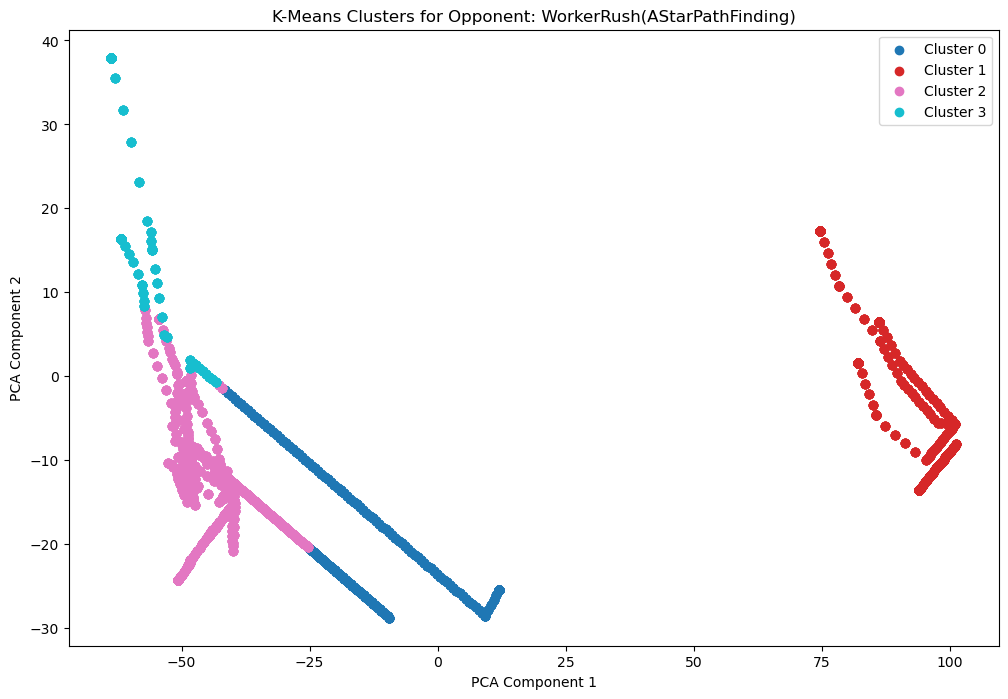

In [120]:
t13.clusterByOpponent(4)

Shape of X_flat: (166618, 190)
Shape of opponent_encoded: (166618,)


C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tadhg\AppData\Local\Temp\ipykernel_23728\1240969211.py:264: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', k_clusters)


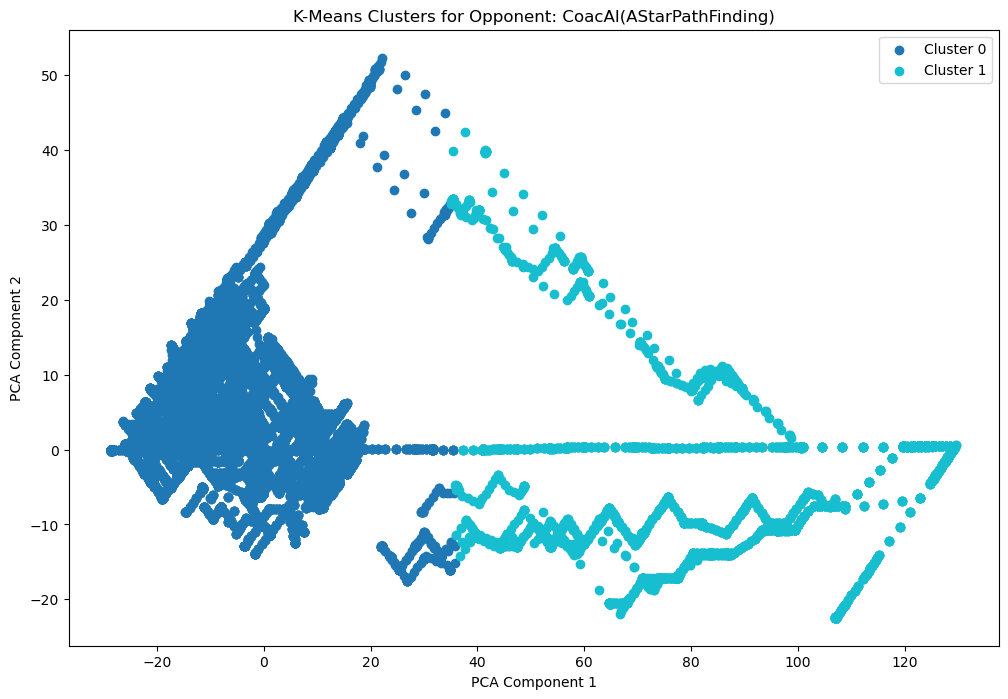

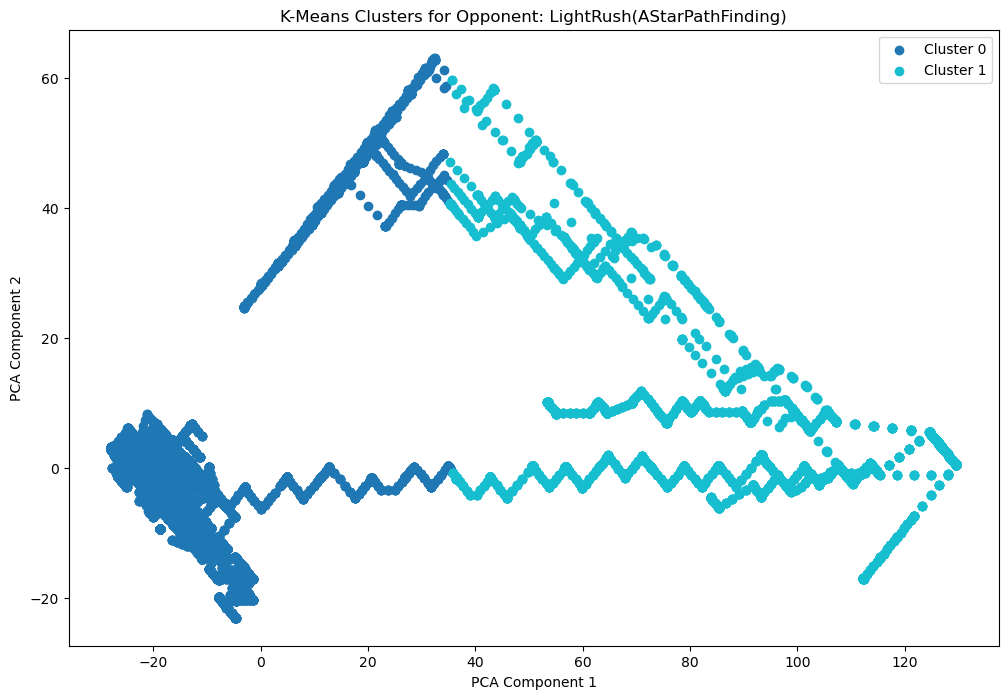

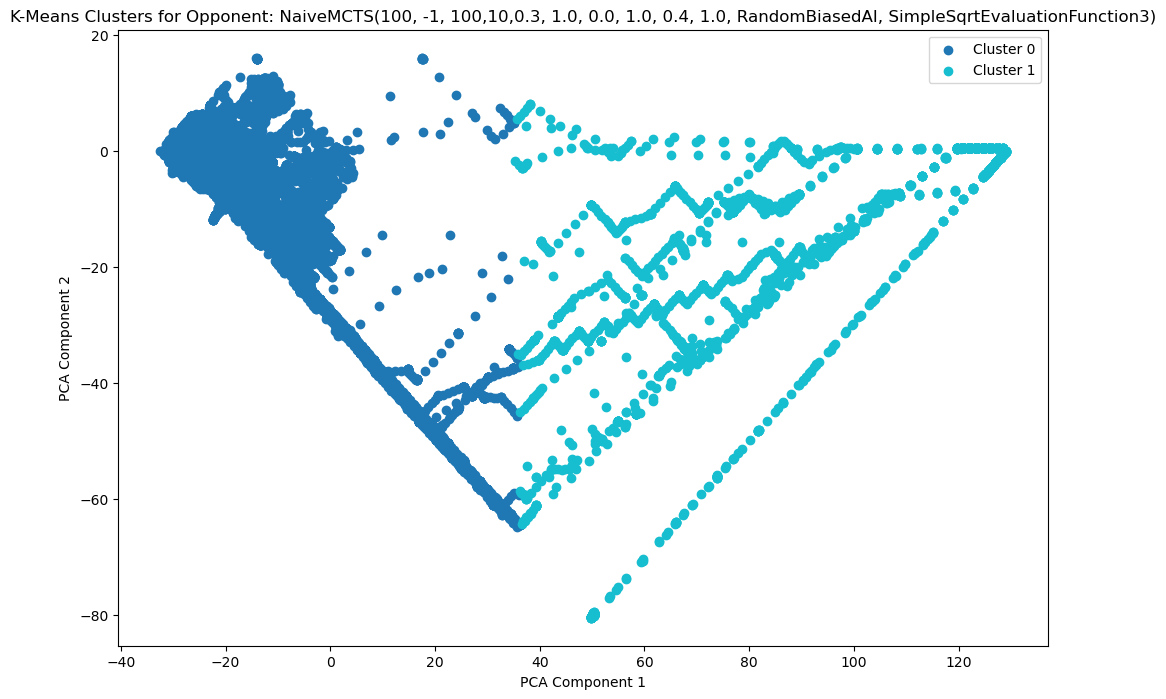

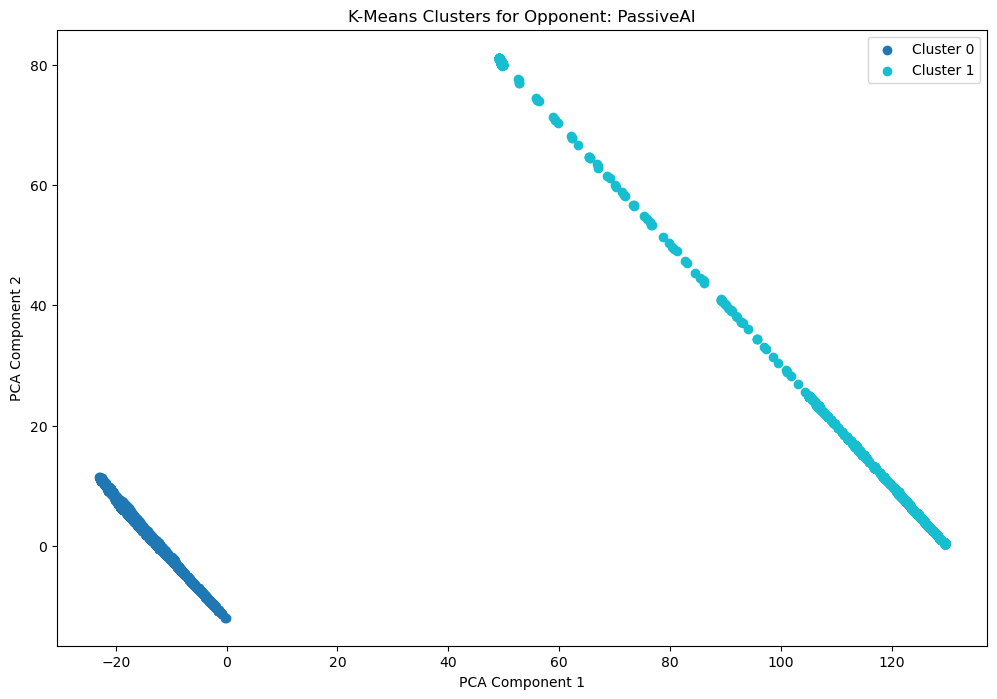

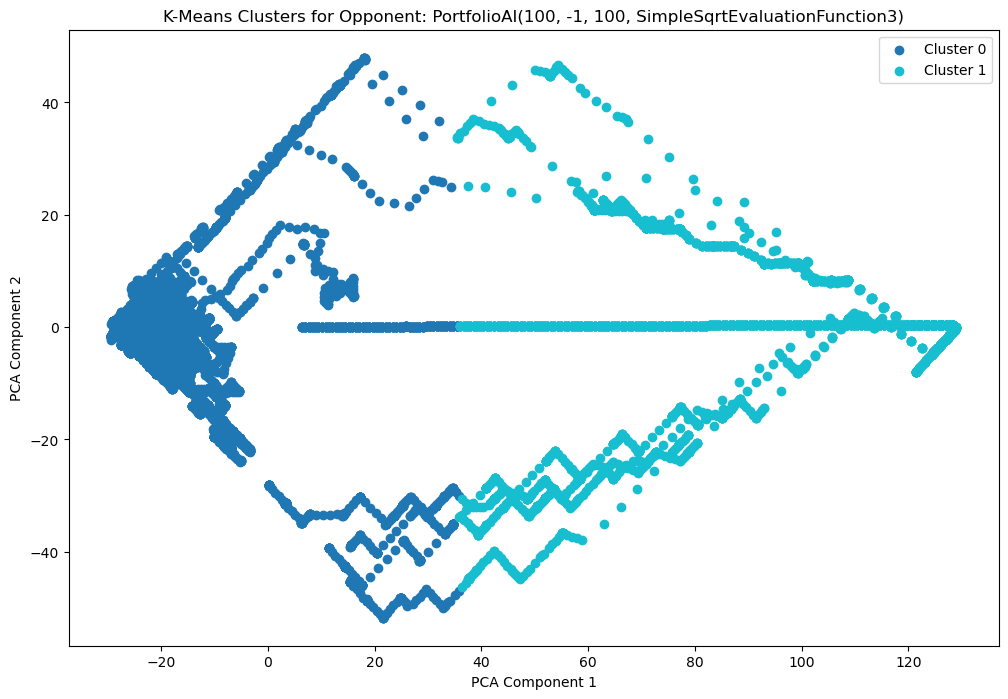

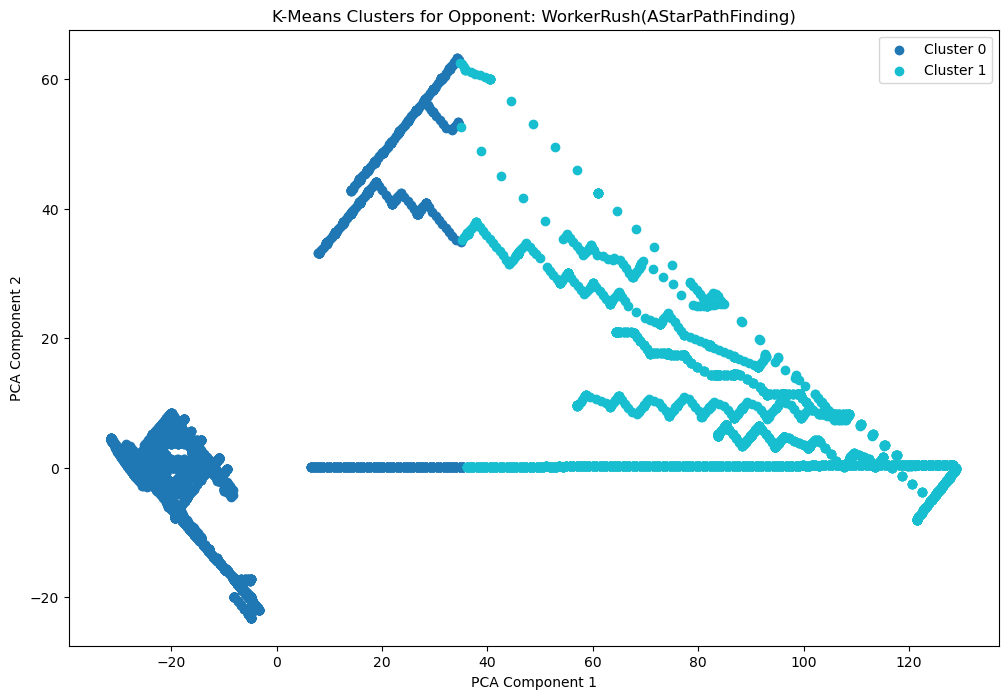

In [87]:
t12.clusterByOpponent(2)

In [122]:
t13.models

{0: 'CoacAI(AStarPathFinding)',
 1: 'WorkerRush(AStarPathFinding)',
 2: 'HeavyDefense(AStarPathFinding)',
 3: 'MLPSMCTS(100, -1, 100, 10, 0.05, RandomBiasedAI, SimpleSqrtEvaluationFunction3)',
 4: 'UCTFirstPlayUrgency(100, -1, 100, 10, RandomBiasedAI, SimpleSqrtEvaluationFunction3, 0.0)',
 5: 'CRush_V1(AStarPathFinding)'}

### ==== END tournament 12

In [219]:
%%time
t7 = TournamentAnalysis("tournament_7")

CPU times: total: 1 s
Wall time: 3.28 s


In [221]:
%%time
t7.preprocess()

CPU times: total: 1.66 s
Wall time: 7.78 s


In [207]:
%%time
t7.train()

CPU times: total: 93.8 ms
Wall time: 975 ms


In [209]:
t7.evaluate(t7.X_test, t7.y_test)

Overall accuracy: 0.9326837909654562
Report:
                              precision    recall  f1-score   support

 HeavyRush(AStarPathFinding)       0.92      0.90      0.91      1113
 LightRush(AStarPathFinding)       0.93      0.94      0.94      1672
RangedRush(AStarPathFinding)       0.91      0.91      0.91      1111
WorkerRush(AStarPathFinding)       1.00      1.00      1.00       620

                    accuracy                           0.93      4516
                   macro avg       0.94      0.94      0.94      4516
                weighted avg       0.93      0.93      0.93      4516

CPU times: total: 78.1 ms
Wall time: 107 ms


array(['LightRush(AStarPathFinding)', 'RangedRush(AStarPathFinding)',
       'LightRush(AStarPathFinding)', ..., 'WorkerRush(AStarPathFinding)',
       'LightRush(AStarPathFinding)', 'HeavyRush(AStarPathFinding)'],
      dtype='<U28')

In [223]:
%%time
t5 = TournamentAnalysis("tournament_5")

CPU times: total: 2min 45s
Wall time: 10min 6s


In [225]:
%%time
t5.preprocess()

CPU times: total: 4min 13s
Wall time: 20min 58s


In [227]:
%%time
t5.train()

CPU times: total: 3min 6s
Wall time: 10min 3s


In [233]:
%%time
t5.evaluate(t5.X_test, t5.y_test)

Overall accuracy: 0.8096149140493195
Report:
                                 precision    recall  f1-score   support

 HeavyDefense(AStarPathFinding)       0.81      0.79      0.80    120919
    HeavyRush(AStarPathFinding)       0.79      0.78      0.78    116624
 LightDefense(AStarPathFinding)       0.83      0.92      0.87     87741
    LightRush(AStarPathFinding)       0.88      0.87      0.87     71384
RangedDefense(AStarPathFinding)       0.70      0.68      0.69     95019
   RangedRush(AStarPathFinding)       0.68      0.67      0.68     92311
WorkerDefense(AStarPathFinding)       0.98      0.98      0.98     87140
   WorkerRush(AStarPathFinding)       0.93      0.93      0.93     27693

                       accuracy                           0.81    698831
                      macro avg       0.82      0.83      0.82    698831
                   weighted avg       0.81      0.81      0.81    698831

CPU times: total: 7.16 s
Wall time: 27.5 s


array(['LightDefense(AStarPathFinding)', 'LightDefense(AStarPathFinding)',
       'WorkerDefense(AStarPathFinding)', ...,
       'RangedRush(AStarPathFinding)', 'WorkerDefense(AStarPathFinding)',
       'LightDefense(AStarPathFinding)'], dtype='<U31')

In [235]:
t5.models

{0: 'WorkerRush(AStarPathFinding)',
 1: 'LightRush(AStarPathFinding)',
 2: 'HeavyRush(AStarPathFinding)',
 3: 'RangedRush(AStarPathFinding)',
 4: 'WorkerDefense(AStarPathFinding)',
 5: 'LightDefense(AStarPathFinding)',
 6: 'HeavyDefense(AStarPathFinding)',
 7: 'RangedDefense(AStarPathFinding)',
 8: nan,
 9: 'C:\\source\\MicroRTS\\maps\\16x16\\basesWorkers16x16.xml',
 10: '100',
 11: '5000',
 12: '100',
 13: '-1',
 14: '1000',
 15: 'TRUE',
 16: 'TRUE',
 17: 'TRUE',
 18: 'FALSE'}

### Tournament 8 - 8 models, 25 iterations

In [26]:
%%time
# load tournament info
tournament_8 = TournamentAnalysis("tournament_8")

CPU times: total: 25.6 s
Wall time: 1min 41s


In [28]:
%%time
# preprocess the data
tournament_8.preprocess(8)

CPU times: total: 54.4 s
Wall time: 3min 51s


In [30]:
%%time
tournament_8.train()

CPU times: total: 32.2 s
Wall time: 1min 59s


In [32]:
%%time
# evaluate the model trained on this tournament
tournament_8.evaluate(tournament_8.X_test, tournament_8.y_test)

Overall accuracy: 0.7960752820692233
Report:
                                 precision    recall  f1-score   support

 HeavyDefense(AStarPathFinding)       0.77      0.76      0.76     20080
    HeavyRush(AStarPathFinding)       0.70      0.74      0.72     17580
 LightDefense(AStarPathFinding)       0.89      0.87      0.88     17645
    LightRush(AStarPathFinding)       0.89      0.88      0.88     17795
RangedDefense(AStarPathFinding)       0.62      0.63      0.62     14680
   RangedRush(AStarPathFinding)       0.68      0.67      0.68     16760
WorkerDefense(AStarPathFinding)       0.98      0.98      0.98     15910
   WorkerRush(AStarPathFinding)       0.93      0.93      0.93      5317

                       accuracy                           0.80    125767
                      macro avg       0.81      0.81      0.81    125767
                   weighted avg       0.80      0.80      0.80    125767

CPU times: total: 672 ms
Wall time: 5.05 s


array(['WorkerDefense(AStarPathFinding)', 'HeavyRush(AStarPathFinding)',
       'LightRush(AStarPathFinding)', ...,
       'HeavyDefense(AStarPathFinding)', 'HeavyRush(AStarPathFinding)',
       'HeavyDefense(AStarPathFinding)'], dtype='<U31')

### Tournament 10 - 5 models, 25 iterations

In [260]:
%%time
# load tournament info
tournament_10 = TournamentAnalysis("tournament_10")

CPU times: total: 7.48 s
Wall time: 49.5 s


In [262]:
# view the models in the tournament
tournament_10.models

{0: 'CoacAI(AStarPathFinding)',
 1: 'WorkerRush(AStarPathFinding)',
 2: 'LightRush(AStarPathFinding)',
 3: 'HeavyRush(AStarPathFinding)',
 4: 'RangedRush(AStarPathFinding)'}

In [40]:
%%time
# preprocess the data
tournament_10.preprocess()


KeyboardInterrupt



In [266]:
%%time
tournament_10.train()

CPU times: total: 11.4 s
Wall time: 24 s


In [268]:
%%time
# evaluate the model trained on this tournament
tournament_10.evaluate(tournament_10.X_test, tournament_10.y_test)

Overall accuracy: 0.9321015917476905
Report:
                              precision    recall  f1-score   support

    CoacAI(AStarPathFinding)       1.00      1.00      1.00     34603
 HeavyRush(AStarPathFinding)       0.80      0.84      0.82      9595
 LightRush(AStarPathFinding)       0.89      0.87      0.88     13470
RangedRush(AStarPathFinding)       0.87      0.85      0.86     12015
WorkerRush(AStarPathFinding)       1.00      1.00      1.00      4575

                    accuracy                           0.93     74258
                   macro avg       0.91      0.91      0.91     74258
                weighted avg       0.93      0.93      0.93     74258

CPU times: total: 953 ms
Wall time: 1.99 s


array(['CoacAI(AStarPathFinding)', 'LightRush(AStarPathFinding)',
       'HeavyRush(AStarPathFinding)', ..., 'LightRush(AStarPathFinding)',
       'CoacAI(AStarPathFinding)', 'CoacAI(AStarPathFinding)'],
      dtype='<U28')

In [296]:
# loop throuh the CoacAI games from tournament 10 and predict them
for i in range (10):
    if(tournament_10.X[i][7] == 0):
        print(tournament_8.classifier.predict(tournament_10.X))

['WorkerRush(AStarPathFinding)' 'WorkerRush(AStarPathFinding)'
 'WorkerRush(AStarPathFinding)' ... 'HeavyRush(AStarPathFinding)'
 'HeavyRush(AStarPathFinding)' 'HeavyRush(AStarPathFinding)']
['WorkerRush(AStarPathFinding)' 'WorkerRush(AStarPathFinding)'
 'WorkerRush(AStarPathFinding)' ... 'HeavyRush(AStarPathFinding)'
 'HeavyRush(AStarPathFinding)' 'HeavyRush(AStarPathFinding)']
['WorkerRush(AStarPathFinding)' 'WorkerRush(AStarPathFinding)'
 'WorkerRush(AStarPathFinding)' ... 'HeavyRush(AStarPathFinding)'
 'HeavyRush(AStarPathFinding)' 'HeavyRush(AStarPathFinding)']
['WorkerRush(AStarPathFinding)' 'WorkerRush(AStarPathFinding)'
 'WorkerRush(AStarPathFinding)' ... 'HeavyRush(AStarPathFinding)'
 'HeavyRush(AStarPathFinding)' 'HeavyRush(AStarPathFinding)']
['WorkerRush(AStarPathFinding)' 'WorkerRush(AStarPathFinding)'
 'WorkerRush(AStarPathFinding)' ... 'HeavyRush(AStarPathFinding)'
 'HeavyRush(AStarPathFinding)' 'HeavyRush(AStarPathFinding)']
['WorkerRush(AStarPathFinding)' 'WorkerRush(A

C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

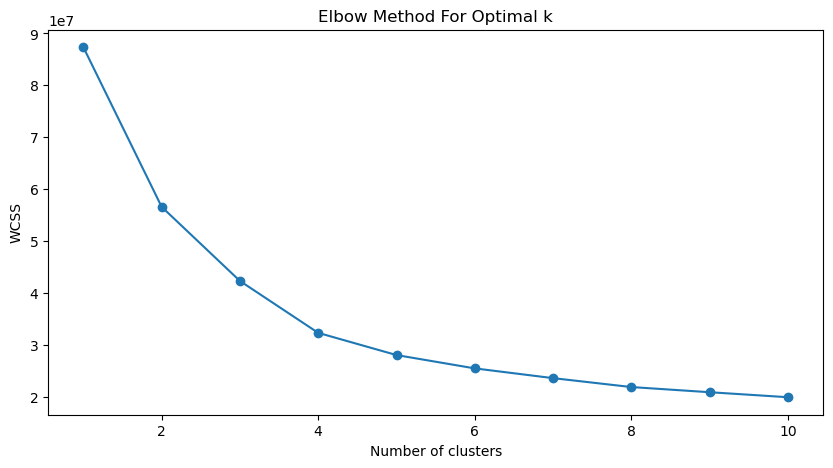

CPU times: total: 10min 59s
Wall time: 6min 36s


In [38]:
%%time
tournament_10 = TournamentAnalysis("tournament_10")
tournament_10.preprocess()
tournament_10.elbowForOptimalK()

In [42]:
tournament_10.models

{0: 'CoacAI(AStarPathFinding)',
 1: 'WorkerRush(AStarPathFinding)',
 2: 'LightRush(AStarPathFinding)',
 3: 'HeavyRush(AStarPathFinding)',
 4: 'RangedRush(AStarPathFinding)'}

C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    time         game_id                  opponent  cluster
0      0  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
1      0  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
2     20  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
3     30  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
4     40  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
5     50  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
6     51  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
7     52  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
8     53  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
9     54  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
10    55  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
11    56  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
12    57  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
13    58  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
14    59  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0


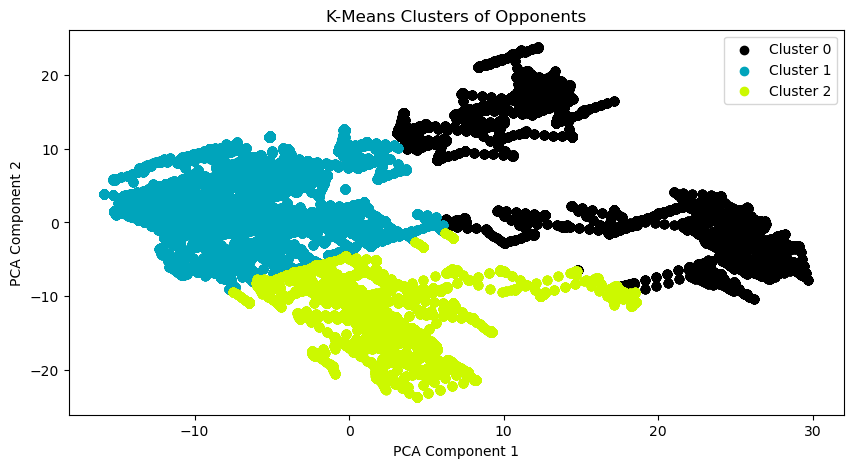

In [44]:
tournament_10.cluster(3)

Shape of X_flat: (371288, 190)
Shape of opponent_encoded: (371288,)


C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Shape of y_kmeans: (371288,)


C:\Users\tadhg\AppData\Local\Temp\ipykernel_23728\1792860480.py:266: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', k_clusters)


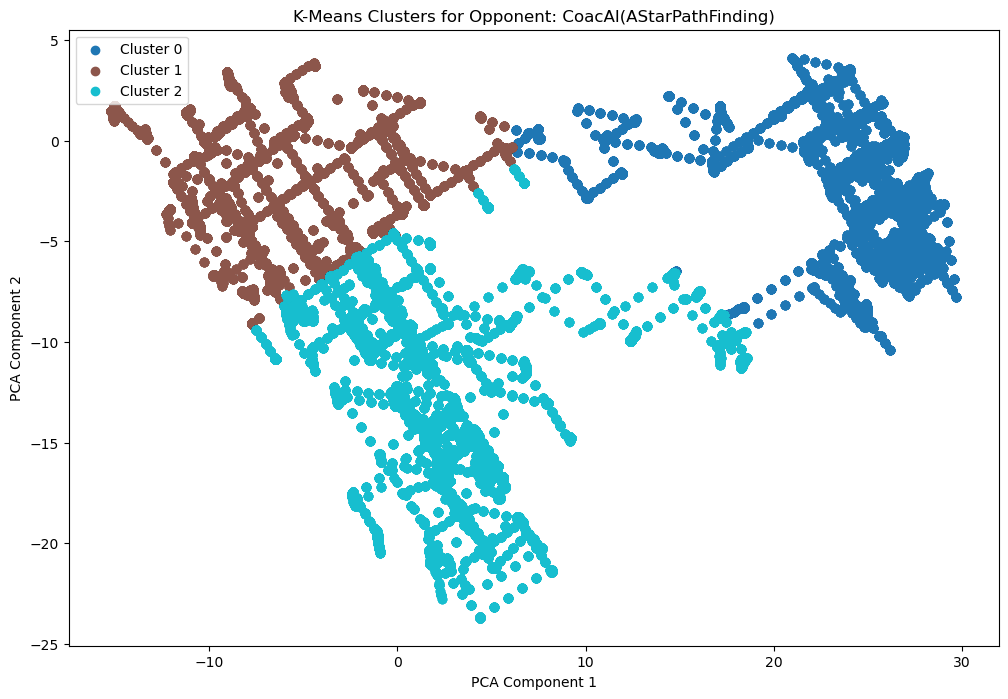

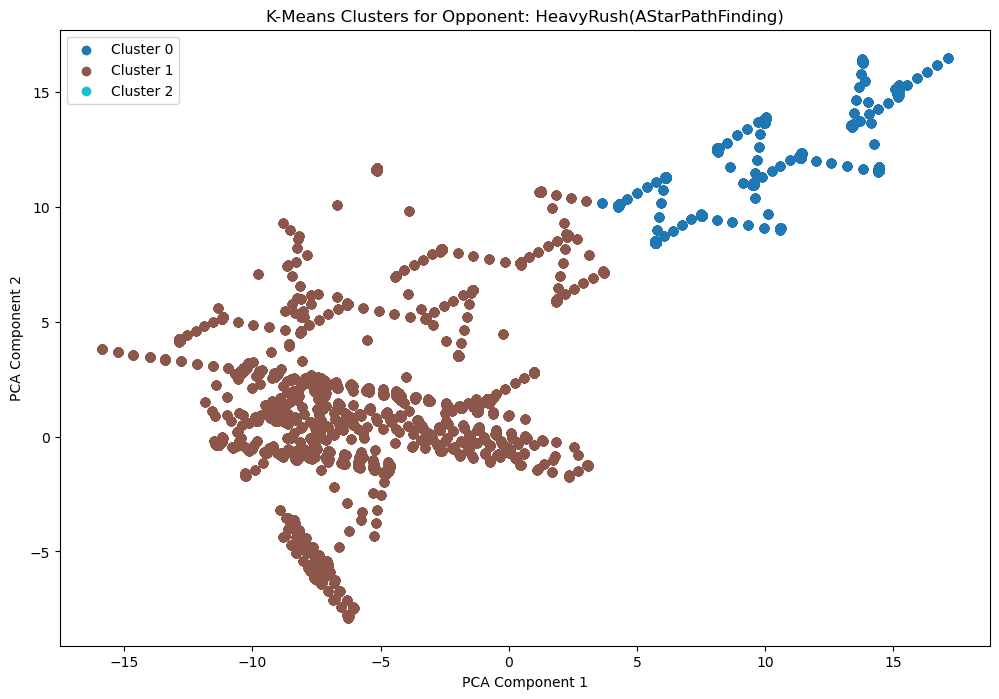

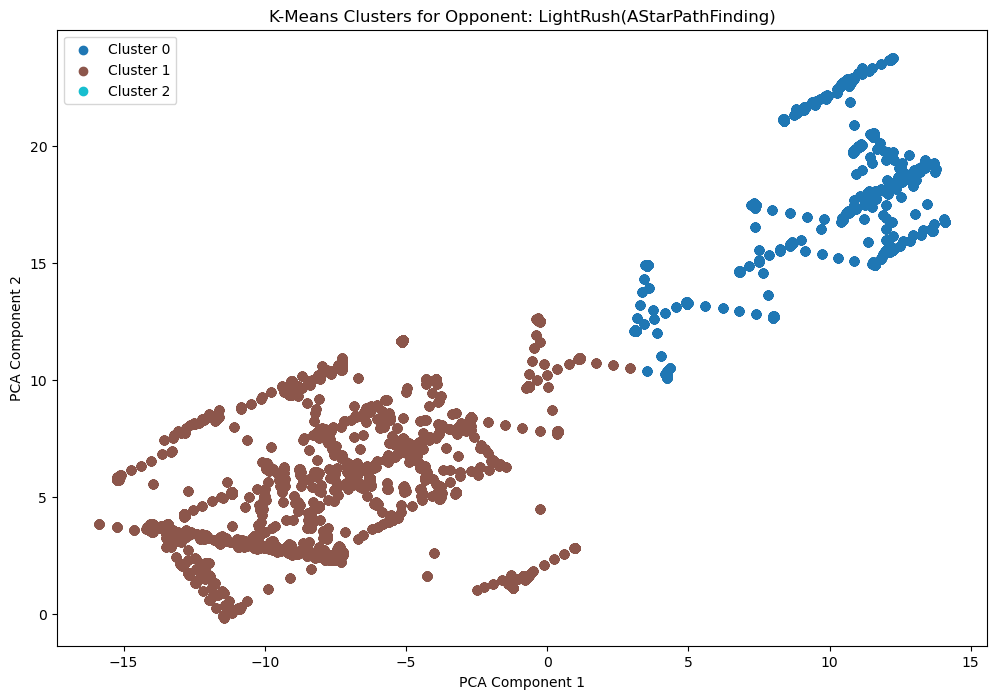

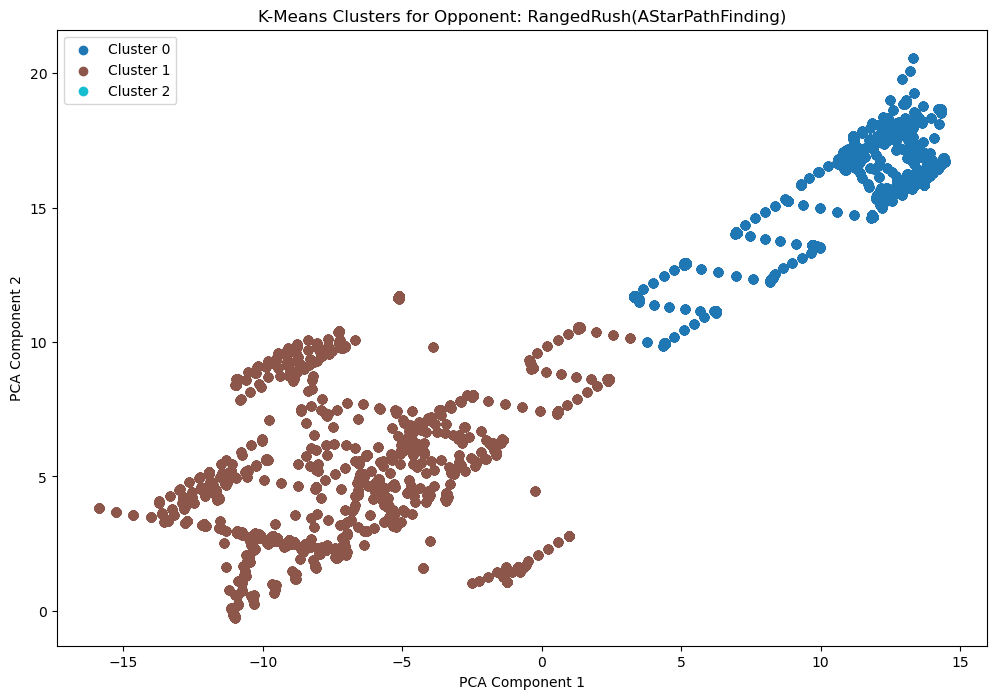

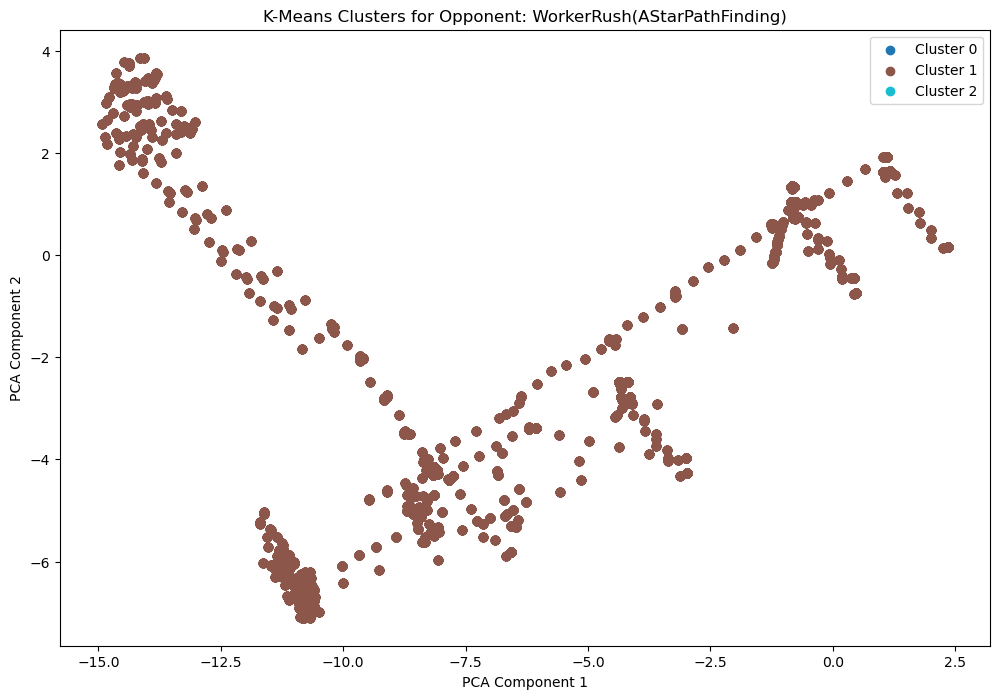

    time         game_id                  opponent  cluster
0      0  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
1      0  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
2     20  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
3     30  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
4     40  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
5     50  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
6     51  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
7     52  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
8     53  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
9     54  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
10    55  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
11    56  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
12    57  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
13    58  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0
14    59  0-vs-0-0-0.zip  CoacAI(AStarPathFinding)      1.0


In [46]:
tournament_10.clusterByOpponent(3)

### Tournament 15

In [236]:
%%time
t15 = TournamentAnalysis("tournament_15", 0.1)

CPU times: total: 6.97 s
Wall time: 27.1 s


In [238]:
%%time
t15.preprocess()

CPU times: total: 24.6 s
Wall time: 1min 26s


In [240]:
%%time
t15.train()

CPU times: total: 6.72 s
Wall time: 26.9 s


In [242]:
t15.evaluate(t15.X_test, t12.y_test)

Overall accuracy: 0.818094865440633
Report:
                              precision    recall  f1-score   support

  Aggrobot(AStarPathFinding)       0.56      0.56      0.56      2817
    CoacAI(AStarPathFinding)       0.96      0.94      0.95      9272
 HeavyRush(AStarPathFinding)       0.56      0.56      0.56      3632
 LightRush(AStarPathFinding)       0.79      0.76      0.77      6638
RangedRush(AStarPathFinding)       0.54      0.57      0.56      3572
WorkerRush(AStarPathFinding)       0.58      0.58      0.58      2962
                      mayari       0.98      0.97      0.97     12969
                      sophia       0.88      0.95      0.91      4140

                    accuracy                           0.82     46002
                   macro avg       0.73      0.74      0.73     46002
                weighted avg       0.82      0.82      0.82     46002



array(['CoacAI(AStarPathFinding)', 'WorkerRush(AStarPathFinding)',
       'HeavyRush(AStarPathFinding)', ..., 'Aggrobot(AStarPathFinding)',
       'RangedRush(AStarPathFinding)', 'WorkerRush(AStarPathFinding)'],
      dtype='<U28')

C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

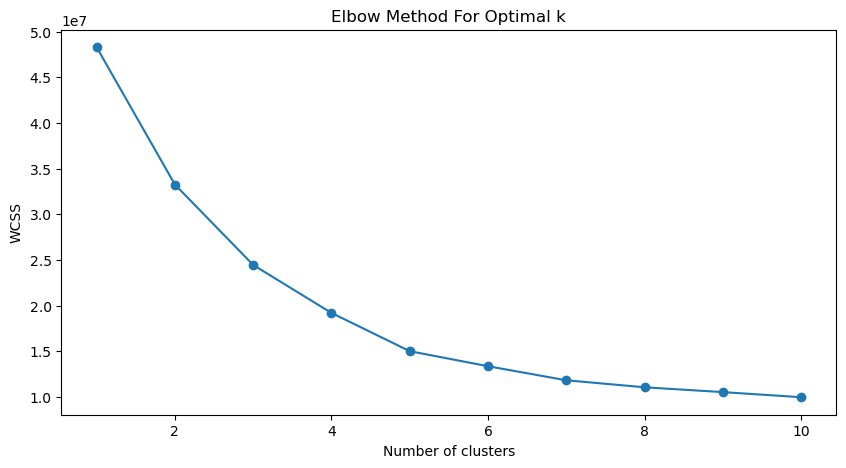

CPU times: total: 35 s
Wall time: 26.8 s


In [244]:
%%time
t15.elbowForOptimalK()

C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


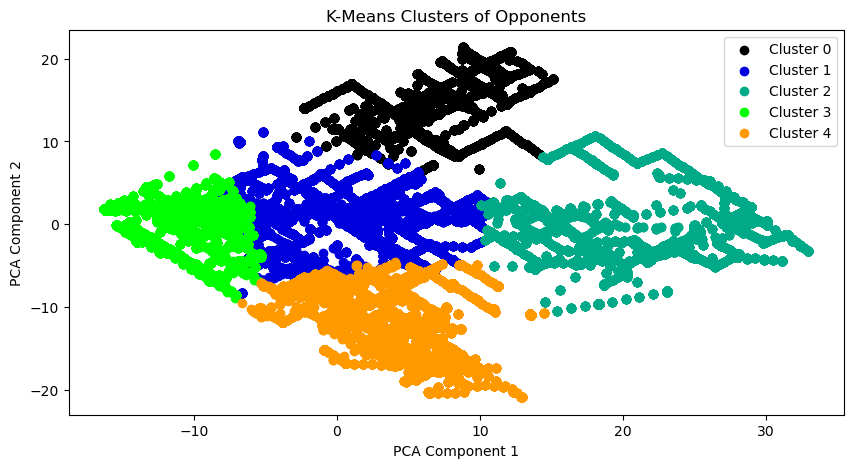

In [246]:
t15.cluster(5);

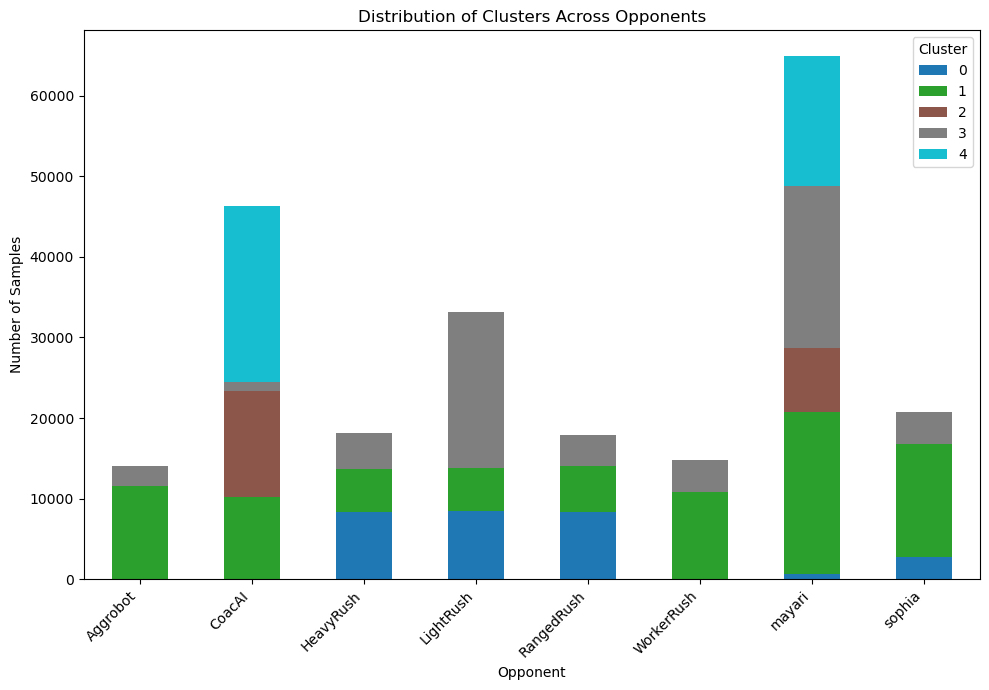

In [248]:
t15.clusterBarchart(5);

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (36,) and arg 3 with shape (37,).

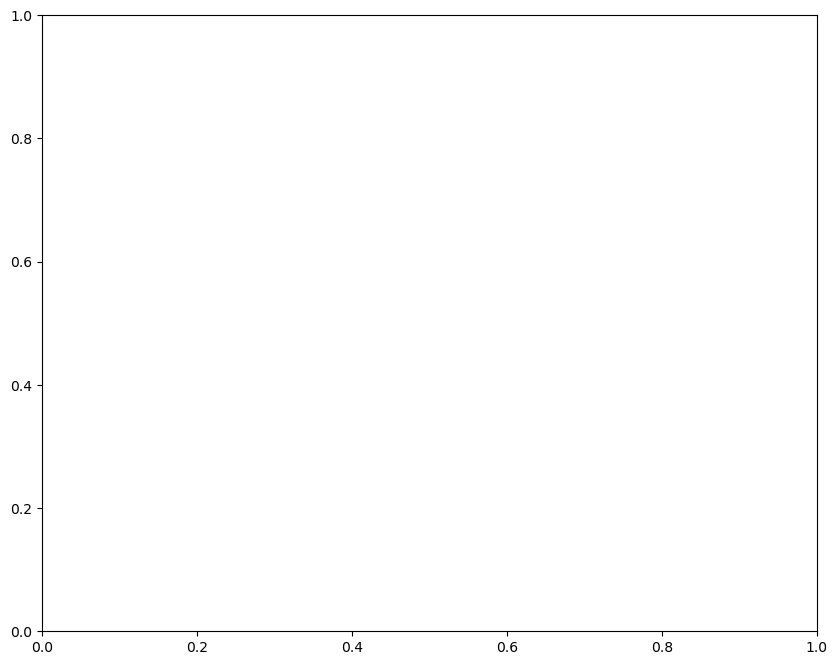

In [224]:
t15.ClusterTraceChart(1)

### Baseline Model Analysis

In [474]:
%%time
t22 = TournamentAnalysis("tournament_22", 0.1)

CPU times: total: 18.8 s
Wall time: 44.7 s


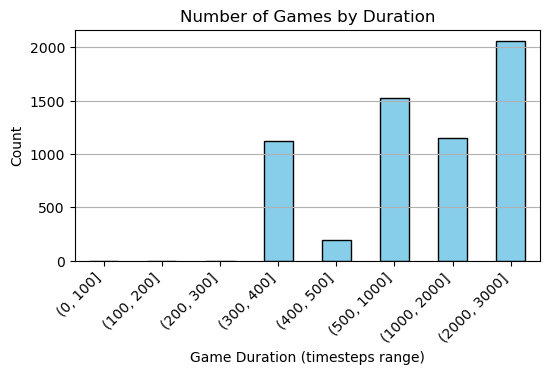

In [480]:
t22.PlotGameLength([0, 100, 200, 300, 400, 500, 1000, 2000, 3000], (6, 3))

In [494]:
t22_1_10.PlotOppponent()

AttributeError: 'TournamentAnalysis' object has no attribute 'PlotOppponent'

In [ ]:
%%time
t22.preprocess()

In [ ]:
%%time
t22.train()

In [ ]:
t22.evaluate(t22.X_test, t22.y_test)

In [532]:
%%time
t22_5 = TournamentAnalysis("tournament_22", 0.1)
t22_10 = copy(t22_5)
t22_20 = copy(t22_5)
t22_30 = copy(t22_5)

CPU times: total: 16.2 s
Wall time: 47.4 s


In [536]:
%%time
t22_5.preprocess(5)
t22_10.preprocess(10)
t22_20.preprocess(20)
t22_30.preprocess(30)

CPU times: total: 3min 11s
Wall time: 7min 32s


In [538]:
%%time
t22_5.train()
t22_10.train()
t22_20.train()
t22_30.train()

CPU times: total: 2min 43s
Wall time: 6min 3s


In [540]:
%%time
t22_5.evaluate(t22_5.X_test, t22_5.y_test)
t22_10.evaluate(t22_10.X_test, t22_10.y_test)
t22_20.evaluate(t22_20.X_test, t22_20.y_test)
t22_30.evaluate(t22_30.X_test, t22_30.y_test)

Overall accuracy: 0.7487190668265562
Report:
                    precision    recall  f1-score   support

      HeavyDefense       0.71      0.75      0.73      5175
         HeavyRush       0.68      0.66      0.67      3870
      LightDefense       0.88      0.85      0.86      4609
         LightRush       0.83      0.83      0.83      3908
         PassiveAI       1.00      1.00      1.00      3071
          RandomAI       1.00      0.99      1.00      2003
     RangedDefense       0.58      0.57      0.57      3415
        RangedRush       0.59      0.60      0.59      3593
     WorkerDefense       0.95      0.94      0.95      4009
        WorkerRush       0.31      0.32      0.31      1524
WorkerRushPlusPlus       0.30      0.30      0.30      1515

          accuracy                           0.75     36692
         macro avg       0.71      0.71      0.71     36692
      weighted avg       0.75      0.75      0.75     36692

Overall accuracy: 0.7685088633993743
Report:
       

array(['PassiveAI', 'HeavyDefense', 'HeavyDefense', ..., 'LightRush',
       'PassiveAI', 'WorkerRushPlusPlus'], dtype='<U18')

In [429]:
%%time
t22_1_5 = TournamentAnalysis("tournament_22")
t22_1_5.preprocess(5)

CPU times: total: 13min 9s
Wall time: 27min 22s


In [333]:
%%time
t22_1_10.preprocess(10)

CPU times: total: 59.1 s
Wall time: 1min 52s


In [334]:
%%time
t22_1_25.preprocess(25)

CPU times: total: 51 s
Wall time: 1min 44s


In [335]:
%%time
t22_1_50.preprocess(50)

CPU times: total: 47.9 s
Wall time: 1min 33s


In [431]:
%%time
t22_1_5.train()
t22_1_5.evaluate(t22_1_5.X_test, t22_1_5.y_test)

Overall accuracy: 0.7874447901481691
Report:
                    precision    recall  f1-score   support

      HeavyDefense       0.81      0.78      0.79     51309
         HeavyRush       0.73      0.71      0.72     38935
      LightDefense       0.88      0.87      0.87     46040
         LightRush       0.78      0.87      0.82     39349
         PassiveAI       1.00      1.00      1.00     30372
          RandomAI       1.00      0.99      1.00     21493
     RangedDefense       0.66      0.64      0.65     34465
        RangedRush       0.66      0.65      0.66     35975
     WorkerDefense       0.96      0.95      0.96     39359
        WorkerRush       0.42      0.43      0.42     15204
WorkerRushPlusPlus       0.41      0.42      0.42     15187

          accuracy                           0.79    367688
         macro avg       0.76      0.76      0.76    367688
      weighted avg       0.79      0.79      0.79    367688

CPU times: total: 4min 2s
Wall time: 8min 2s


array(['RangedRush', 'LightDefense', 'HeavyRush', ..., 'HeavyDefense',
       'LightDefense', 'WorkerDefense'], dtype='<U18')

C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


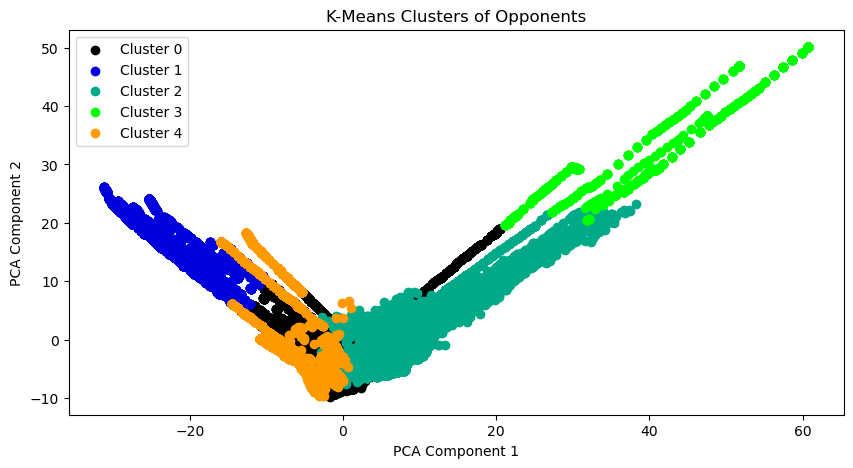

In [554]:
t22_5.cluster(5)

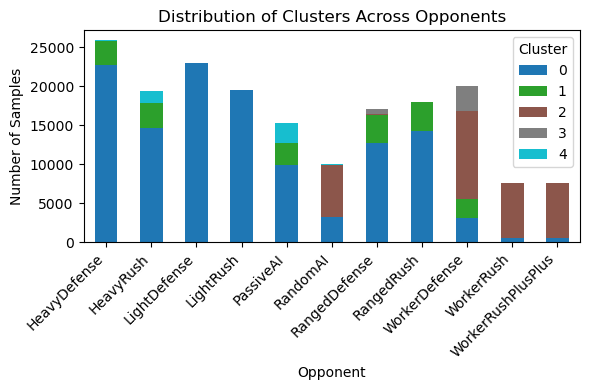

In [556]:
t22_5.clusterBarchart(5, (6, 4))

C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


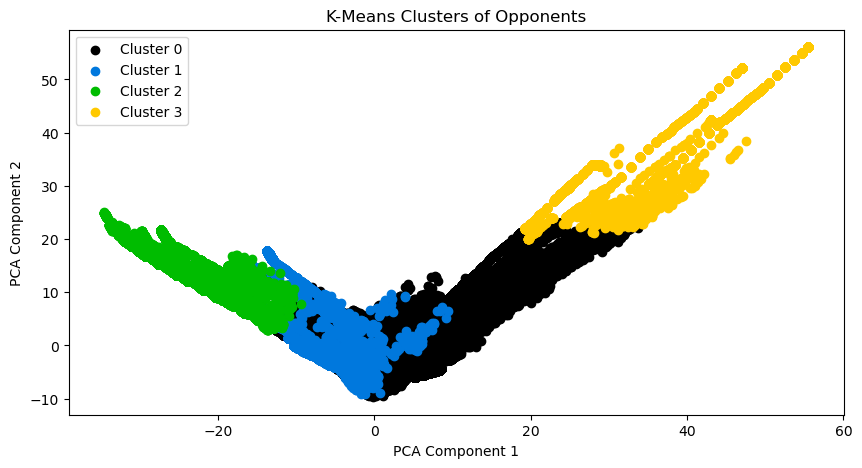

In [440]:
t22_1_5.cluster(4)

C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


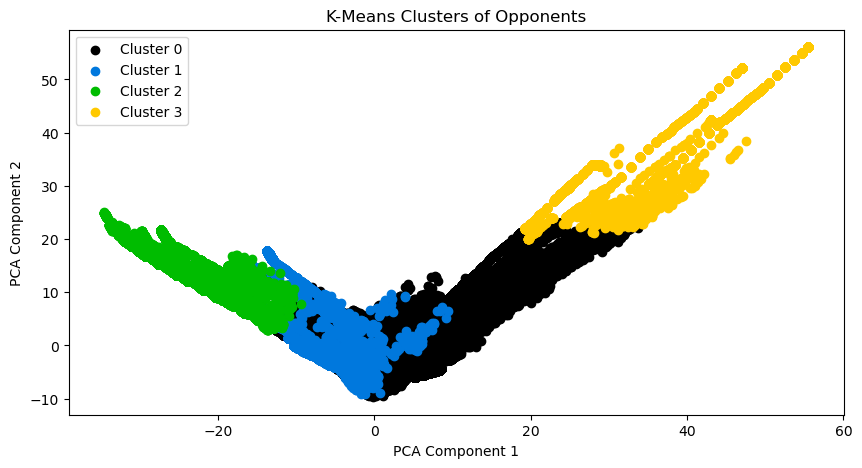

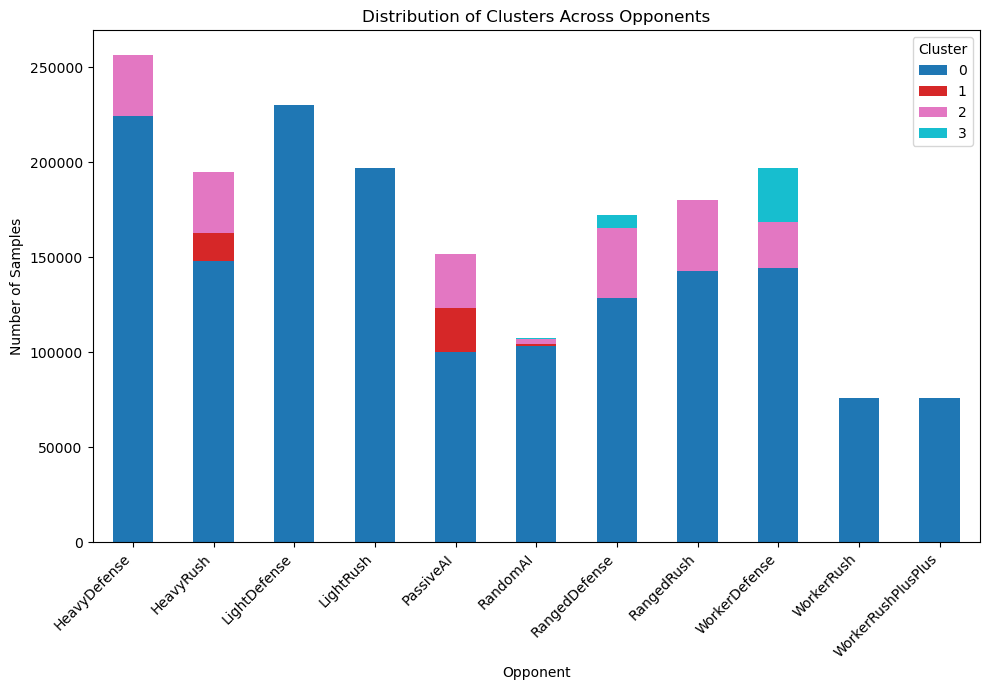

In [544]:
t22_1_5.cluster(4)
t22_1_5.clusterBarchart(4)

C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

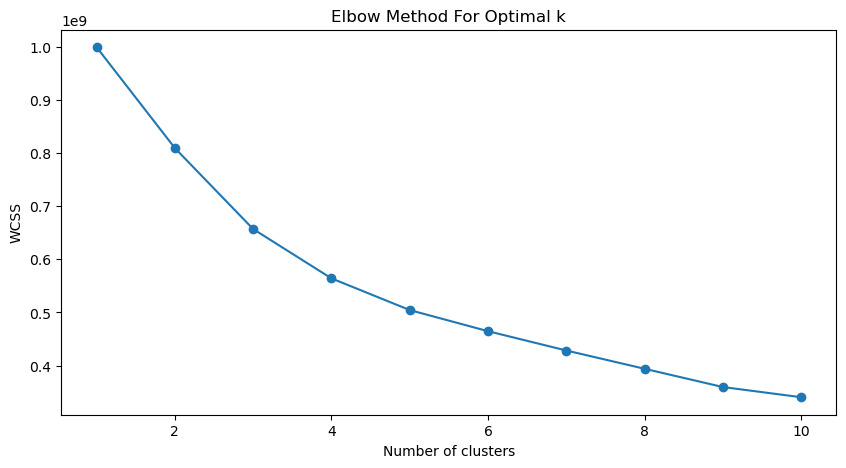

In [436]:
t22_1_5.elbowForOptimalK()

In [341]:
%%time
t22_1_10.train()

CPU times: total: 41.9 s
Wall time: 1min 6s


In [342]:
%%time
t22_1_25.train()

CPU times: total: 1min 27s
Wall time: 2min 10s


In [343]:
%%time
t22_1_50.train()

CPU times: total: 2min 2s
Wall time: 3min 8s


In [348]:
%%time
t22_1_5.evaluate(t22_1_5.X_test, t22_1_5.y_test)
t22_1_10.evaluate(t22_1_10.X_test, t22_1_10.y_test)
t22_1_25.evaluate(t22_1_25.X_test, t22_1_25.y_test)
t22_1_50.evaluate(t22_1_50.X_test, t22_1_50.y_test)

Overall accuracy: 0.7487190668265562
Report:
                    precision    recall  f1-score   support

      HeavyDefense       0.71      0.75      0.73      5175
         HeavyRush       0.68      0.66      0.67      3870
      LightDefense       0.88      0.85      0.86      4609
         LightRush       0.83      0.83      0.83      3908
         PassiveAI       1.00      1.00      1.00      3071
          RandomAI       1.00      0.99      1.00      2003
     RangedDefense       0.58      0.57      0.57      3415
        RangedRush       0.59      0.60      0.59      3593
     WorkerDefense       0.95      0.94      0.95      4009
        WorkerRush       0.31      0.32      0.31      1524
WorkerRushPlusPlus       0.30      0.30      0.30      1515

          accuracy                           0.75     36692
         macro avg       0.71      0.71      0.71     36692
      weighted avg       0.75      0.75      0.75     36692

Overall accuracy: 0.7685088633993743
Report:
       

array(['LightRush', 'PassiveAI', 'HeavyRush', ..., 'WorkerDefense',
       'LightRush', 'LightRush'], dtype='<U18')

In [352]:
%%time
t22_1_100 = TournamentAnalysis("tournament_22", 0.2)
t22_1_200.PlotGameLength()
t22_1_100.preprocess(100)
t22_1_100.train()
t22_1_100.evaluate(t22_1_100.X_test, t22_1_100.y_test)

Overall accuracy: 0.8626322719071536
Report:
                    precision    recall  f1-score   support

      HeavyDefense       0.86      0.88      0.87      6740
         HeavyRush       0.81      0.78      0.80      4515
      LightDefense       0.96      0.96      0.96      5770
         LightRush       0.95      0.95      0.95      5237
         PassiveAI       1.00      1.00      1.00      3248
          RandomAI       1.00      1.00      1.00      1400
     RangedDefense       0.71      0.68      0.69      3484
        RangedRush       0.73      0.76      0.75      4064
     WorkerDefense       1.00      1.00      1.00      4356
        WorkerRush       0.40      0.38      0.39      1009
WorkerRushPlusPlus       0.49      0.50      0.50      1191

          accuracy                           0.86     41014
         macro avg       0.81      0.81      0.81     41014
      weighted avg       0.86      0.86      0.86     41014

CPU times: total: 5min 44s
Wall time: 12min 2s


array(['LightRush', 'WorkerRush', 'RangedDefense', ..., 'WorkerDefense',
       'HeavyRush', 'HeavyRush'], dtype='<U18')

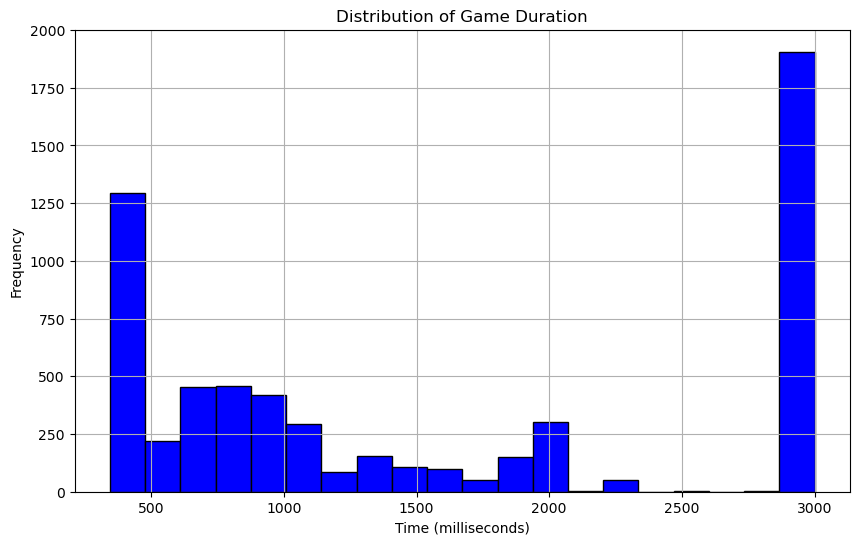

Overall accuracy: 0.8612438168519849
Report:


C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    precision    recall  f1-score   support

      HeavyDefense       0.86      0.87      0.86      5344
         HeavyRush       0.69      0.67      0.68      2304
      LightDefense       0.98      1.00      0.99      3773
         LightRush       1.00      0.97      0.99      3614
         PassiveAI       1.00      1.00      1.00      1545
          RandomAI       1.00      1.00      1.00       481
     RangedDefense       0.58      0.58      0.58      2060
        RangedRush       0.61      0.61      0.61      2192
     WorkerDefense       1.00      1.00      1.00      2055
        WorkerRush       0.99      1.00      1.00       283
WorkerRushPlusPlus       0.00      0.00      0.00         2

          accuracy                           0.86     23653
         macro avg       0.79      0.79      0.79     23653
      weighted avg       0.86      0.86      0.86     23653

CPU times: total: 6min 18s
Wall time: 12min 23s


C:\Users\tadhg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array(['RangedRush', 'HeavyDefense', 'HeavyDefense', ..., 'RangedRush',
       'RangedRush', 'PassiveAI'], dtype='<U18')

In [358]:
%%time
t22_1_200 = TournamentAnalysis("tournament_22", 0.2)
t22_1_200.PlotGameLength()
t22_1_200.preprocess(200)
t22_1_200.train()
t22_1_200.evaluate(t22_1_200.X_test, t22_1_200.y_test)

## Tournament 24

In [561]:
%%time
tournament_24 = TournamentAnalysis("tournament_24")

CPU times: total: 6min 59s
Wall time: 14min 54s


In [565]:
len(tournament_24.traces)

4202147

In [ ]:
%%time
tournament_24.preprocess(30)

In [ ]:
len(tournament_24.X)

In [ ]:
tournament_24.PlotGameLength([0, 100, 200, 300, 400, 500, 1000, 2000, 3000], (6, 3))

In [ ]:
%%time
tournament_24.train()
tournament_24.evaluate(tournament_24.X_test, tournament_24.y_test)